In [2]:
!pip install transformers torch pandas numpy scikit-learn
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 4.7 MB/s eta 0:00:00


##Oversampling = 500 & Undersampling = 3000, Epoch = 5, Learning Rate = 1e-5, Batch Size = 8, Split 60 30 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Training Loss: 0.6124, Training Acc: 0.7708, Validation Loss: 0.4465, Validation Acc: 0.8350
Epoch 2/5, Training Loss: 0.4806, Training Acc: 0.8163, Validation Loss: 0.3916, Validation Acc: 0.8438
Epoch 3/5, Training Loss: 0.4268, Training Acc: 0.8408, Validation Loss: 0.3620, Validation Acc: 0.8700
Epoch 4/5, Training Loss: 0.3805, Training Acc: 0.8629, Validation Loss: 0.3261, Validation Acc: 0.8950
Epoch 5/5, Training Loss: 0.3487, Training Acc: 0.8750, Validation Loss: 0.3429, Validation Acc: 0.8912
Test Loss: 0.4213, Test Accuracy: 0.8512


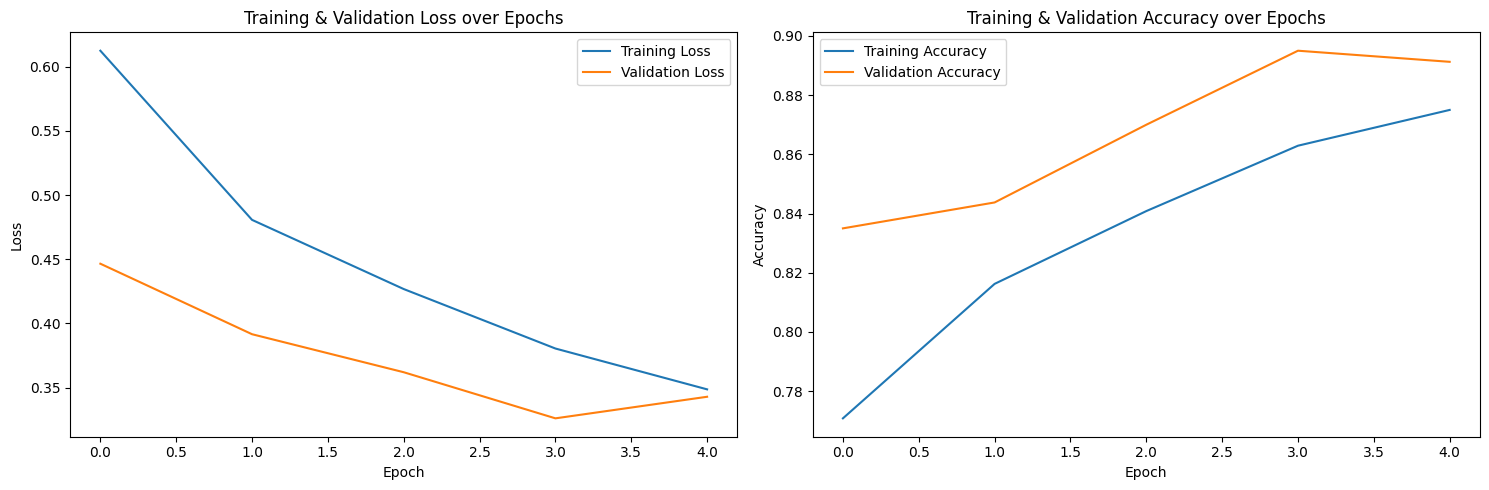

In [ ]:
import pandas as pd
import torch
from sklearn.utils import resample
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. Memuat dataset
file_path = "/content/segari_clean_yeah_drop888.csv"
df = pd.read_csv(file_path)

# 2. Mapping score ke label
df['label'] = df['score'].apply(lambda x: 'negative' if x in [1, 2] else ('neutral' if x == 3 else 'positive'))
label_to_id = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label_id'] = df['label'].map(label_to_id)

# 3. Resampling data
# Oversampling negative class
df_negative = df[df['label'] == 'negative']
df_negative_oversampled = resample(df_negative, replace=True, n_samples=500, random_state=42)

# Oversampling neutral class
df_neutral = df[df['label'] == 'neutral']
df_neutral_oversampled = resample(df_neutral, replace=True, n_samples=500, random_state=42)

# Undersampling positive class
df_positive = df[df['label'] == 'positive']
df_positive_undersampled = resample(df_positive, replace=False, n_samples=3000, random_state=42)

# Combining the resampled data
df_resampled = pd.concat([df_negative_oversampled, df_neutral_oversampled, df_positive_undersampled])

# 4. Split resampled data
train_df, temp_df = train_test_split(df_resampled, test_size=0.4, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)  # 50-50 split for valid-test from temp_df

# 5. Tokenization
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
train_encodings = tokenizer(train_df['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")
valid_encodings = tokenizer(valid_df['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")
test_encodings = tokenizer(test_df['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")

# ... [remaining code remains the same as yours]
# 6. DataLoader
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(train_encodings.input_ids, train_encodings.attention_mask, torch.tensor(train_df['label_id'].tolist()))
valid_dataset = TensorDataset(valid_encodings.input_ids, valid_encodings.attention_mask, torch.tensor(valid_df['label_id'].tolist()))
test_dataset = TensorDataset(test_encodings.input_ids, test_encodings.attention_mask, torch.tensor(test_df['label_id'].tolist()))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# 7. Model & Optimizer
config = BertConfig.from_pretrained("indobenchmark/indobert-base-p2", num_labels=3)
config.hidden_dropout_prob = 0.5
model = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p2", config=config)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# 7a. Tambahkan Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.1, verbose=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 8. Training Loop dengan Early Stopping dan Scheduler
num_epochs = 5
best_val_loss = float('inf')
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
n_epochs_stop = 3
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_count = 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_correct += (logits.argmax(dim=1) == labels).sum().item()
        total_count += labels.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_accs.append(total_correct / total_count)

    model.eval()
    total_val_loss = 0
    total_val_correct = 0
    total_val_count = 0

    with torch.no_grad():
        for batch in valid_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss, logits = outputs.loss, outputs.logits
            total_val_loss += loss.item()
            total_val_correct += (logits.argmax(dim=1) == labels).sum().item()
            total_val_count += labels.size(0)

    avg_val_loss = total_val_loss / len(valid_loader)
    valid_losses.append(avg_val_loss)
    valid_accs.append(total_val_correct / total_val_count)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Training Acc: {train_accs[-1]:.4f}, Validation Loss: {valid_losses[-1]:.4f}, Validation Acc: {valid_accs[-1]:.4f}")

    # Update scheduler
    scheduler.step(avg_val_loss)

    # Implementasi Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == n_epochs_stop:
            print(f"Early stopping after {epochs_no_improve} epochs!")
            break

# Muat model dengan bobot terbaik
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

# Evaluasi pada data pengujian
total_test_correct = 0
total_test_count = 0
test_losses = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        test_losses.append(loss.item())
        total_test_correct += (logits.argmax(dim=1) == labels).sum().item()
        total_test_count += labels.size(0)

avg_test_loss = sum(test_losses) / len(test_losses)
test_accuracy = total_test_correct / total_test_count

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# 9. Visualization

# 9a. Visualisasi Loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss over Epochs")

# 9b. Visualisasi Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Training Accuracy")
plt.plot(valid_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy over Epochs")
plt.tight_layout()
plt.show()

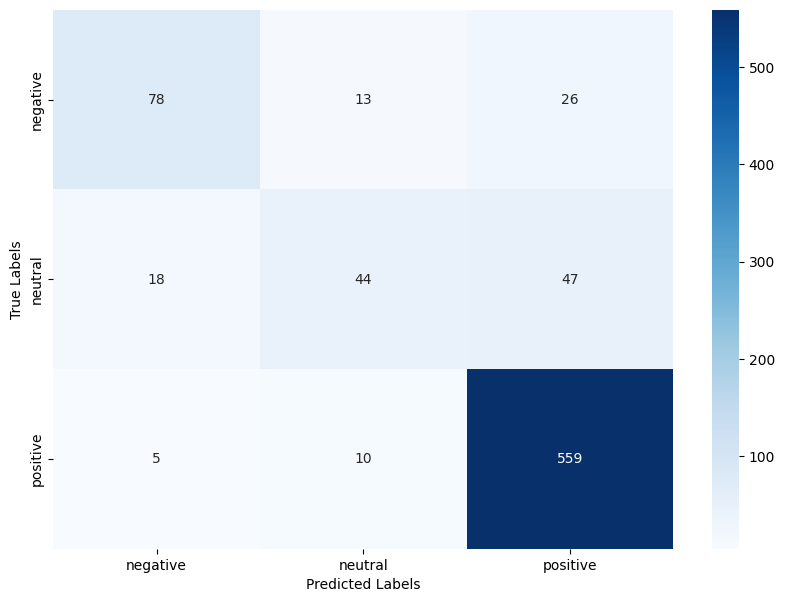

              precision    recall  f1-score   support

    negative       0.77      0.67      0.72       117
     neutral       0.66      0.40      0.50       109
    positive       0.88      0.97      0.93       574

    accuracy                           0.85       800
   macro avg       0.77      0.68      0.71       800
weighted avg       0.84      0.85      0.84       800



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 1. Prediksi Label pada Dataset Pengujian
model.eval()
all_predictions = []
all_true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = logits.argmax(dim=1).cpu().numpy()
        true_labels = labels.cpu().numpy()

        all_predictions.extend(predictions)
        all_true_labels.extend(true_labels)

# 2. Buat Confusion Matrix & Classification Report

# Confusion Matrix
cm = confusion_matrix(all_true_labels, all_predictions)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_to_id.keys(),
            yticklabels=label_to_id.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
report = classification_report(all_true_labels, all_predictions, target_names=label_to_id.keys())
print(report)

##Oversampling = 500 & Undersampling = 3000, Epoch = 5, Learning Rate = 3e-6, Batch Size = 32, Split 60 30 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Training Loss: 0.6997, Training Acc: 0.7533, Validation Loss: 0.6468, Validation Acc: 0.7775
Epoch 2/5, Training Loss: 0.6013, Training Acc: 0.7842, Validation Loss: 0.6018, Validation Acc: 0.8050
Epoch 3/5, Training Loss: 0.5227, Training Acc: 0.8013, Validation Loss: 0.5343, Validation Acc: 0.8137
Epoch 4/5, Training Loss: 0.4972, Training Acc: 0.8117, Validation Loss: 0.5763, Validation Acc: 0.8063
Epoch 5/5, Training Loss: 0.4654, Training Acc: 0.8263, Validation Loss: 0.5320, Validation Acc: 0.8263
Test Loss: 0.6753, Test Accuracy: 0.7850


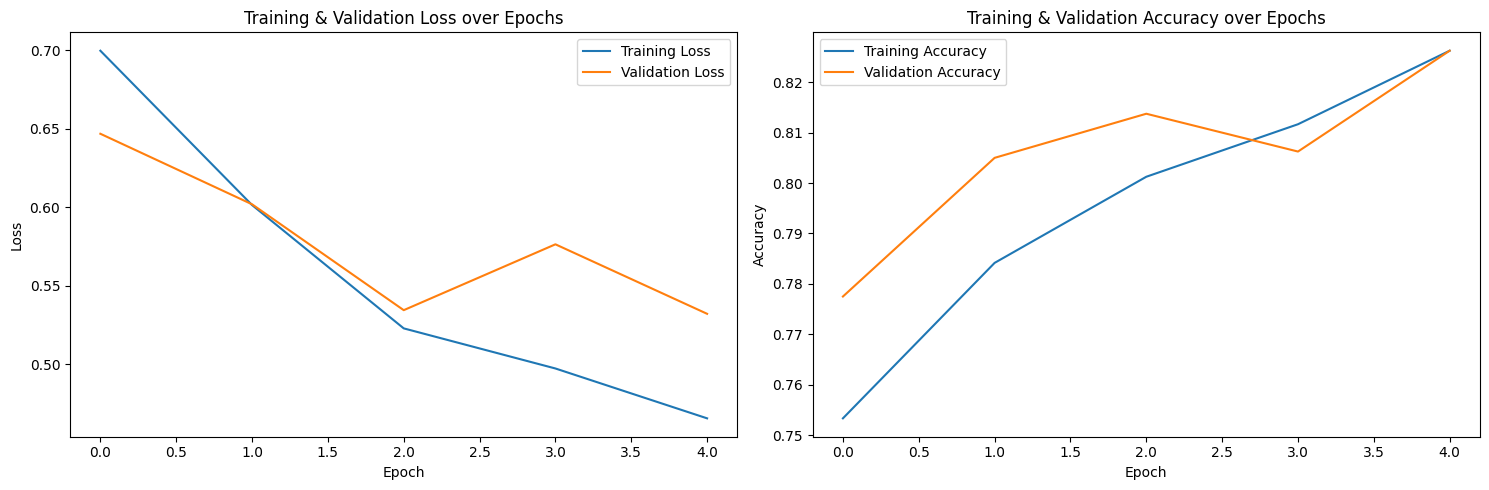

In [ ]:
import pandas as pd
import torch
from sklearn.utils import resample
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. Memuat dataset
file_path = "/content/segari_clean_yeah_drop888.csv"
df = pd.read_csv(file_path)

# 2. Mapping score ke label
df['label'] = df['score'].apply(lambda x: 'negative' if x in [1, 2] else ('neutral' if x == 3 else 'positive'))
label_to_id = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label_id'] = df['label'].map(label_to_id)

# 3. Resampling data
# Oversampling negative class
df_negative = df[df['label'] == 'negative']
df_negative_oversampled = resample(df_negative, replace=True, n_samples=500, random_state=42)

# Oversampling neutral class
df_neutral = df[df['label'] == 'neutral']
df_neutral_oversampled = resample(df_neutral, replace=True, n_samples=500, random_state=42)

# Undersampling positive class
df_positive = df[df['label'] == 'positive']
df_positive_undersampled = resample(df_positive, replace=False, n_samples=3000, random_state=42)

# Combining the resampled data
df_resampled = pd.concat([df_negative_oversampled, df_neutral_oversampled, df_positive_undersampled])

# 4. Split resampled data
train_df, temp_df = train_test_split(df_resampled, test_size=0.4, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)  # 50-50 split for valid-test from temp_df

# 5. Tokenization
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
train_encodings = tokenizer(train_df['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")
valid_encodings = tokenizer(valid_df['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")
test_encodings = tokenizer(test_df['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")

# ... [remaining code remains the same as yours]
# 6. DataLoader
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(train_encodings.input_ids, train_encodings.attention_mask, torch.tensor(train_df['label_id'].tolist()))
valid_dataset = TensorDataset(valid_encodings.input_ids, valid_encodings.attention_mask, torch.tensor(valid_df['label_id'].tolist()))
test_dataset = TensorDataset(test_encodings.input_ids, test_encodings.attention_mask, torch.tensor(test_df['label_id'].tolist()))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# 7. Model & Optimizer
config = BertConfig.from_pretrained("indobenchmark/indobert-base-p2", num_labels=3)
config.hidden_dropout_prob = 0.5
model = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p2", config=config)
optimizer = optim.Adam(model.parameters(), lr=3e-6)

# 7a. Tambahkan Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.1, verbose=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 8. Training Loop dengan Early Stopping dan Scheduler
num_epochs = 5
best_val_loss = float('inf')
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
n_epochs_stop = 3
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_count = 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_correct += (logits.argmax(dim=1) == labels).sum().item()
        total_count += labels.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_accs.append(total_correct / total_count)

    model.eval()
    total_val_loss = 0
    total_val_correct = 0
    total_val_count = 0

    with torch.no_grad():
        for batch in valid_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss, logits = outputs.loss, outputs.logits
            total_val_loss += loss.item()
            total_val_correct += (logits.argmax(dim=1) == labels).sum().item()
            total_val_count += labels.size(0)

    avg_val_loss = total_val_loss / len(valid_loader)
    valid_losses.append(avg_val_loss)
    valid_accs.append(total_val_correct / total_val_count)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Training Acc: {train_accs[-1]:.4f}, Validation Loss: {valid_losses[-1]:.4f}, Validation Acc: {valid_accs[-1]:.4f}")

    # Update scheduler
    scheduler.step(avg_val_loss)

    # Implementasi Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == n_epochs_stop:
            print(f"Early stopping after {epochs_no_improve} epochs!")
            break

# Muat model dengan bobot terbaik
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

# Evaluasi pada data pengujian
total_test_correct = 0
total_test_count = 0
test_losses = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        test_losses.append(loss.item())
        total_test_correct += (logits.argmax(dim=1) == labels).sum().item()
        total_test_count += labels.size(0)

avg_test_loss = sum(test_losses) / len(test_losses)
test_accuracy = total_test_correct / total_test_count

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# 9. Visualization

# 9a. Visualisasi Loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss over Epochs")

# 9b. Visualisasi Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Training Accuracy")
plt.plot(valid_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy over Epochs")
plt.tight_layout()
plt.show()

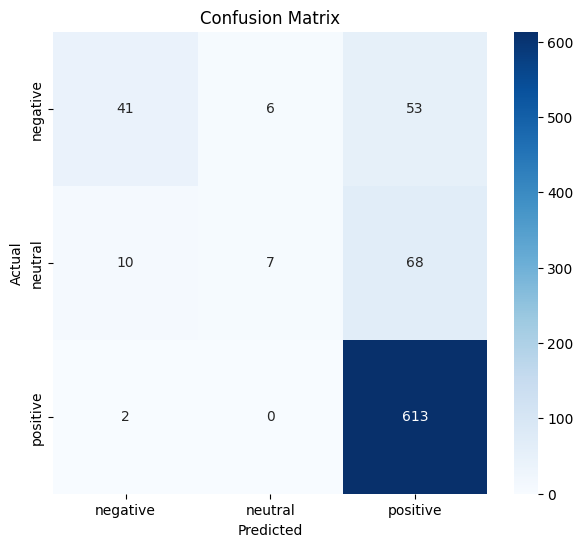

              precision    recall  f1-score   support

    negative       0.77      0.41      0.54       100
     neutral       0.54      0.08      0.14        85
    positive       0.84      1.00      0.91       615

    accuracy                           0.83       800
   macro avg       0.72      0.50      0.53       800
weighted avg       0.80      0.83      0.78       800

Accuracy Score: 0.8263


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

# 10. Evaluasi model
# Memuat model terbaik yang telah disimpan
model.load_state_dict(torch.load('best_model.pt'))

model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for batch in valid_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        all_preds.extend(logits.argmax(dim=1).cpu().numpy())
        all_true.extend(labels.cpu().numpy())

# 11. Confusion Matrix
conf_matrix = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap="Blues",
            xticklabels=label_to_id.keys(), yticklabels=label_to_id.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 12. Classification Report
report = classification_report(all_true, all_preds, target_names=label_to_id.keys())
print(report)

# 13. Accuracy Score
acc_score = accuracy_score(all_true, all_preds)
print(f"Accuracy Score: {acc_score:.4f}")

##Oversampling & Undersampling = N , Epoch = 5, Learning Rate = 1e-5, Batch Size = 8, Split 60 30 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Training Loss: 0.7694, Training Acc: 0.6454, Validation Loss: 0.4866, Validation Acc: 0.8070
Epoch 2/5, Training Loss: 0.4102, Training Acc: 0.8432, Validation Loss: 0.2513, Validation Acc: 0.9070
Epoch 3/5, Training Loss: 0.2735, Training Acc: 0.9003, Validation Loss: 0.1995, Validation Acc: 0.9304
Epoch 4/5, Training Loss: 0.2091, Training Acc: 0.9206, Validation Loss: 0.1978, Validation Acc: 0.9301
Epoch 5/5, Training Loss: 0.1773, Training Acc: 0.9346, Validation Loss: 0.1787, Validation Acc: 0.9315
Test Loss: 0.1678, Test Accuracy: 0.9408


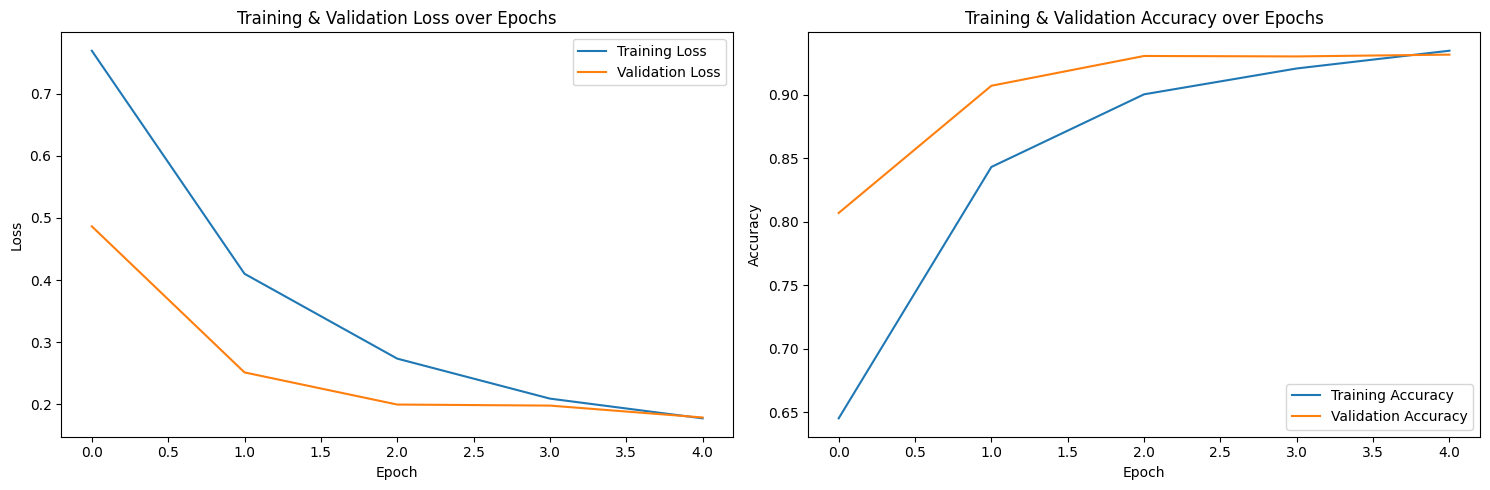

In [ ]:
import pandas as pd
import torch
from sklearn.utils import resample
from torch import optim
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. Memuat dataset
file_path = "/content/segari_clean_yeah_drop888.csv"
df = pd.read_csv(file_path)

# 2. Mapping score ke label
df['label'] = df['score'].apply(lambda x: 'negative' if x in [1, 2] else ('neutral' if x == 3 else 'positive'))

# 3. Konversi label ke id
label_to_id = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label_id'] = df['label'].map(label_to_id)

# Resampling data
target_samples = 4697

# Oversampling negative class
df_negative = df[df['label'] == 'negative']
df_negative_oversampled = resample(df_negative, replace=True, n_samples=target_samples, random_state=42)

# Oversampling neutral class
df_neutral = df[df['label'] == 'neutral']
df_neutral_oversampled = resample(df_neutral, replace=True, n_samples=target_samples, random_state=42)

# Using positive class as it is (or we can undersample it if needed)
df_positive = df[df['label'] == 'positive']

# Combining the resampled data
df_resampled = pd.concat([df_negative_oversampled, df_neutral_oversampled, df_positive])

# 4. Split resampled data
train_df, temp_df = train_test_split(df_resampled, test_size=0.4, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)  # 50-50 split for valid-test from temp_df

# 5. Tokenization
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
train_encodings = tokenizer(train_df['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")
valid_encodings = tokenizer(valid_df['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")
test_encodings = tokenizer(test_df['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")

# ... [remaining code remains the same as yours]
# 6. DataLoader
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(train_encodings.input_ids, train_encodings.attention_mask, torch.tensor(train_df['label_id'].tolist()))
valid_dataset = TensorDataset(valid_encodings.input_ids, valid_encodings.attention_mask, torch.tensor(valid_df['label_id'].tolist()))
test_dataset = TensorDataset(test_encodings.input_ids, test_encodings.attention_mask, torch.tensor(test_df['label_id'].tolist()))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# 7. Model & Optimizer
config = BertConfig.from_pretrained("indobenchmark/indobert-base-p2", num_labels=3)
config.hidden_dropout_prob = 0.5
model = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p2", config=config)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# 7a. Tambahkan Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.1, verbose=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 8. Training Loop dengan Early Stopping dan Scheduler
num_epochs = 5
best_val_loss = float('inf')
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
n_epochs_stop = 3
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_count = 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_correct += (logits.argmax(dim=1) == labels).sum().item()
        total_count += labels.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_accs.append(total_correct / total_count)

    model.eval()
    total_val_loss = 0
    total_val_correct = 0
    total_val_count = 0

    with torch.no_grad():
        for batch in valid_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss, logits = outputs.loss, outputs.logits
            total_val_loss += loss.item()
            total_val_correct += (logits.argmax(dim=1) == labels).sum().item()
            total_val_count += labels.size(0)

    avg_val_loss = total_val_loss / len(valid_loader)
    valid_losses.append(avg_val_loss)
    valid_accs.append(total_val_correct / total_val_count)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Training Acc: {train_accs[-1]:.4f}, Validation Loss: {valid_losses[-1]:.4f}, Validation Acc: {valid_accs[-1]:.4f}")

    # Update scheduler
    scheduler.step(avg_val_loss)

    # Implementasi Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == n_epochs_stop:
            print(f"Early stopping after {epochs_no_improve} epochs!")
            break

# Muat model dengan bobot terbaik
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

# Evaluasi pada data pengujian
total_test_correct = 0
total_test_count = 0
test_losses = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        test_losses.append(loss.item())
        total_test_correct += (logits.argmax(dim=1) == labels).sum().item()
        total_test_count += labels.size(0)

avg_test_loss = sum(test_losses) / len(test_losses)
test_accuracy = total_test_correct / total_test_count

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# 9. Visualization
# 9a. Visualisasi Loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss over Epochs")

# 9b. Visualisasi Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Training Accuracy")
plt.plot(valid_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy over Epochs")
plt.tight_layout()
plt.show()

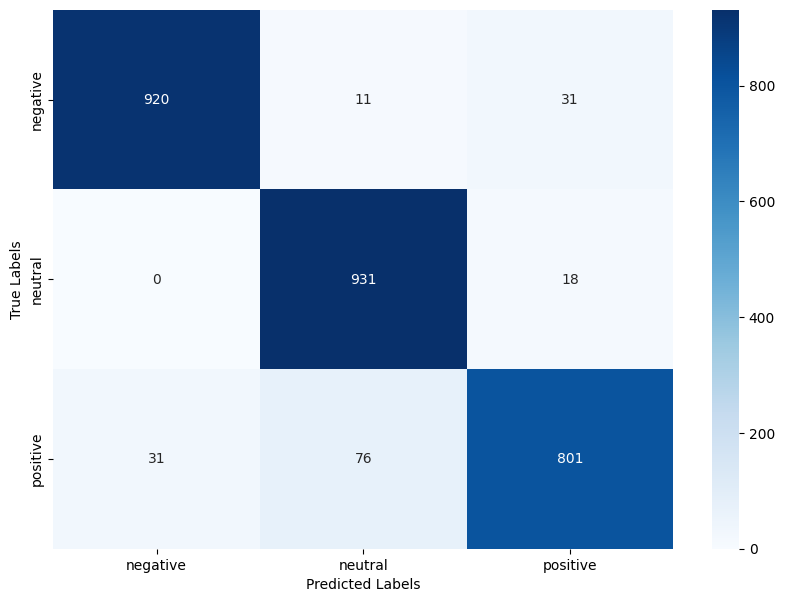

              precision    recall  f1-score   support

    negative       0.97      0.96      0.96       962
     neutral       0.91      0.98      0.95       949
    positive       0.94      0.88      0.91       908

    accuracy                           0.94      2819
   macro avg       0.94      0.94      0.94      2819
weighted avg       0.94      0.94      0.94      2819



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 1. Prediksi Label pada Dataset Pengujian
model.eval()
all_predictions = []
all_true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = logits.argmax(dim=1).cpu().numpy()
        true_labels = labels.cpu().numpy()

        all_predictions.extend(predictions)
        all_true_labels.extend(true_labels)

# 2. Buat Confusion Matrix & Classification Report

# Confusion Matrix
cm = confusion_matrix(all_true_labels, all_predictions)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_to_id.keys(),
            yticklabels=label_to_id.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
report = classification_report(all_true_labels, all_predictions, target_names=label_to_id.keys())
print(report)

##JANGAN OTAK ATIK KODE DIBAWAH

##Oversampling Negative = 500 , Epoch = 5, Learning Rate = 1e-5, Batch Size = 8, Split 80 20

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Training Loss: 0.5965, Training Acc: 0.7753, Validation Loss: 0.5416, Validation Acc: 0.8087
Epoch 2/5, Training Loss: 0.4695, Training Acc: 0.8181, Validation Loss: 0.4998, Validation Acc: 0.8175
Epoch 3/5, Training Loss: 0.4258, Training Acc: 0.8372, Validation Loss: 0.4576, Validation Acc: 0.8337
Epoch 4/5, Training Loss: 0.3770, Training Acc: 0.8616, Validation Loss: 0.4039, Validation Acc: 0.8588
Epoch 5/5, Training Loss: 0.3221, Training Acc: 0.8881, Validation Loss: 0.4051, Validation Acc: 0.8675


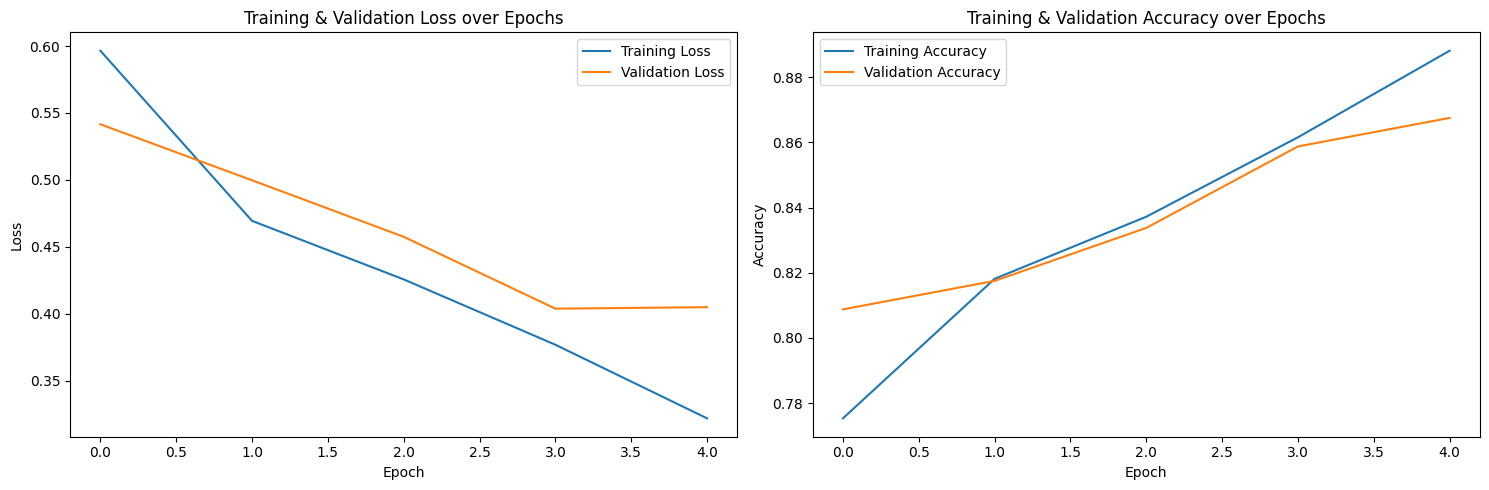

In [ ]:
import pandas as pd
import torch
from sklearn.utils import resample
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim

# 1. Memuat dataset
file_path = "/content/segari_clean_yeah_drop888.csv"
df = pd.read_csv(file_path)

# 2. Mapping score ke label
df['label'] = df['score'].apply(lambda x: 'negative' if x in [1, 2] else ('neutral' if x == 3 else 'positive'))
label_to_id = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label_id'] = df['label'].map(label_to_id)

# 3. Resampling data
# Oversampling negative class
df_negative = df[df['label'] == 'negative']
df_negative_oversampled = resample(df_negative, replace=True, n_samples=500, random_state=42)


# 4. Split resampled data menjadi 80% training dan 20% validasi
train_df, valid_df = train_test_split(df_resampled, test_size=0.2, random_state=42)

# 5. Tokenization
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
train_encodings = tokenizer(train_df['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")
valid_encodings = tokenizer(valid_df['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")

# 6. DataLoader
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(train_encodings.input_ids, train_encodings.attention_mask, torch.tensor(train_df['label_id'].tolist()))
valid_dataset = TensorDataset(valid_encodings.input_ids, valid_encodings.attention_mask, torch.tensor(valid_df['label_id'].tolist()))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

# 7. Model & Optimizer
config = BertConfig.from_pretrained("indobenchmark/indobert-base-p2", num_labels=3)
config.hidden_dropout_prob = 0.5
model = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p2", config=config)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# 7a. Tambahkan Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.1, verbose=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 8. Training Loop dengan Early Stopping dan Scheduler
num_epochs = 5
best_val_loss = float('inf')
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
n_epochs_stop = 3
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_count = 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_correct += (logits.argmax(dim=1) == labels).sum().item()
        total_count += labels.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_accs.append(total_correct / total_count)

    model.eval()
    total_val_loss = 0
    total_val_correct = 0
    total_val_count = 0

    with torch.no_grad():
        for batch in valid_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss, logits = outputs.loss, outputs.logits
            total_val_loss += loss.item()
            total_val_correct += (logits.argmax(dim=1) == labels).sum().item()
            total_val_count += labels.size(0)

    avg_val_loss = total_val_loss / len(valid_loader)
    valid_losses.append(avg_val_loss)
    valid_accs.append(total_val_correct / total_val_count)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Training Acc: {train_accs[-1]:.4f}, Validation Loss: {valid_losses[-1]:.4f}, Validation Acc: {valid_accs[-1]:.4f}")

    # Update scheduler
    scheduler.step(avg_val_loss)

    # Implementasi Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == n_epochs_stop:
            print(f"Early stopping after {epochs_no_improve} epochs!")
            break

# 9. Visualization
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss over Epochs")

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Training Accuracy")
plt.plot(valid_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy over Epochs")
plt.tight_layout()
plt.show()

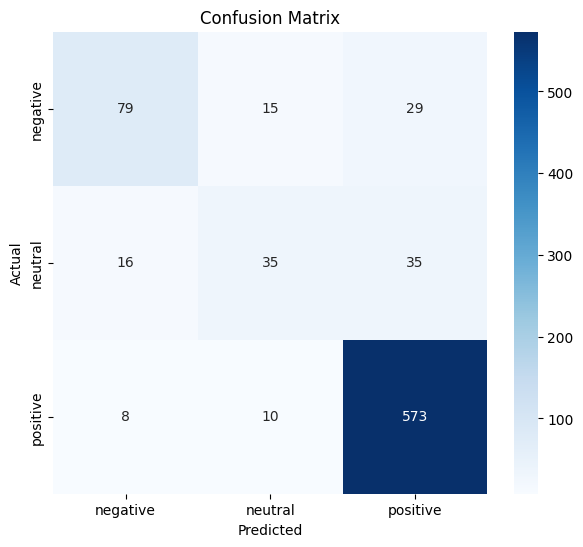

              precision    recall  f1-score   support

    negative       0.77      0.64      0.70       123
     neutral       0.58      0.41      0.48        86
    positive       0.90      0.97      0.93       591

    accuracy                           0.86       800
   macro avg       0.75      0.67      0.70       800
weighted avg       0.85      0.86      0.85       800

Accuracy Score: 0.8588


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

# 10. Evaluasi model
# Memuat model terbaik yang telah disimpan
model.load_state_dict(torch.load('best_model.pt'))

model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for batch in valid_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        all_preds.extend(logits.argmax(dim=1).cpu().numpy())
        all_true.extend(labels.cpu().numpy())

# 11. Confusion Matrix
conf_matrix = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap="Blues",
            xticklabels=label_to_id.keys(), yticklabels=label_to_id.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 12. Classification Report
report = classification_report(all_true, all_preds, target_names=label_to_id.keys())
print(report)

# 13. Accuracy Score
acc_score = accuracy_score(all_true, all_preds)
print(f"Accuracy Score: {acc_score:.4f}")

##Oversampling Negative = 500 , Epoch = 5, Learning Rate = 2e-5, Batch Size = 8, Split 80 20

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Training Loss: 0.5711, Training Acc: 0.7928, Validation Loss: 0.4423, Validation Acc: 0.8413
Epoch 2/5, Training Loss: 0.4314, Training Acc: 0.8363, Validation Loss: 0.4342, Validation Acc: 0.8525
Epoch 3/5, Training Loss: 0.3569, Training Acc: 0.8797, Validation Loss: 0.3863, Validation Acc: 0.8712
Epoch 4/5, Training Loss: 0.2949, Training Acc: 0.9081, Validation Loss: 0.3955, Validation Acc: 0.8712
Epoch 5/5, Training Loss: 0.2624, Training Acc: 0.9181, Validation Loss: 0.3333, Validation Acc: 0.9025


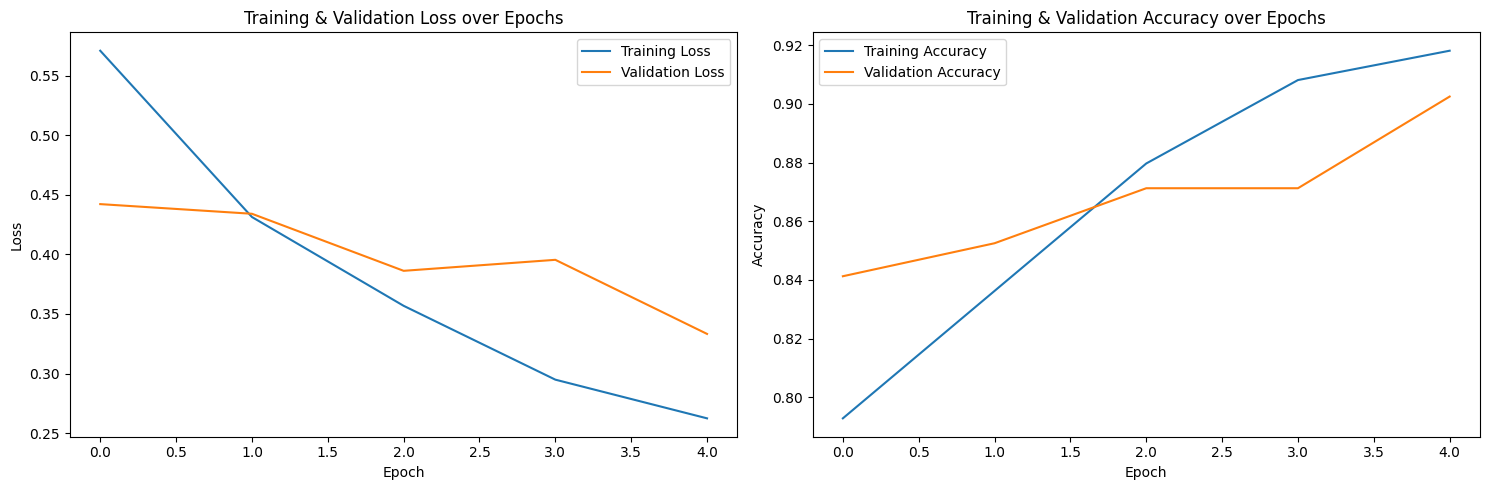

In [ ]:
import pandas as pd
import torch
from sklearn.utils import resample
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim

# 1. Memuat dataset
file_path = "/content/segari_clean_yeah_drop888.csv"
df = pd.read_csv(file_path)

# 2. Mapping score ke label
df['label'] = df['score'].apply(lambda x: 'negative' if x in [1, 2] else ('neutral' if x == 3 else 'positive'))
label_to_id = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label_id'] = df['label'].map(label_to_id)

# 3. Resampling data
# Oversampling negative class
df_negative = df[df['label'] == 'negative']
df_negative_oversampled = resample(df_negative, replace=True, n_samples=500, random_state=42)


# 4. Split resampled data menjadi 80% training dan 20% validasi
train_df, valid_df = train_test_split(df_resampled, test_size=0.2, random_state=42)

# 5. Tokenization
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
train_encodings = tokenizer(train_df['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")
valid_encodings = tokenizer(valid_df['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")

# 6. DataLoader
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(train_encodings.input_ids, train_encodings.attention_mask, torch.tensor(train_df['label_id'].tolist()))
valid_dataset = TensorDataset(valid_encodings.input_ids, valid_encodings.attention_mask, torch.tensor(valid_df['label_id'].tolist()))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

# 7. Model & Optimizer
config = BertConfig.from_pretrained("indobenchmark/indobert-base-p2", num_labels=3)
config.hidden_dropout_prob = 0.5
model = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p2", config=config)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

# 7a. Tambahkan Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.1, verbose=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 8. Training Loop dengan Early Stopping dan Scheduler
num_epochs = 5
best_val_loss = float('inf')
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
n_epochs_stop = 3
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_count = 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_correct += (logits.argmax(dim=1) == labels).sum().item()
        total_count += labels.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_accs.append(total_correct / total_count)

    model.eval()
    total_val_loss = 0
    total_val_correct = 0
    total_val_count = 0

    with torch.no_grad():
        for batch in valid_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss, logits = outputs.loss, outputs.logits
            total_val_loss += loss.item()
            total_val_correct += (logits.argmax(dim=1) == labels).sum().item()
            total_val_count += labels.size(0)

    avg_val_loss = total_val_loss / len(valid_loader)
    valid_losses.append(avg_val_loss)
    valid_accs.append(total_val_correct / total_val_count)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Training Acc: {train_accs[-1]:.4f}, Validation Loss: {valid_losses[-1]:.4f}, Validation Acc: {valid_accs[-1]:.4f}")

    # Update scheduler
    scheduler.step(avg_val_loss)

    # Implementasi Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == n_epochs_stop:
            print(f"Early stopping after {epochs_no_improve} epochs!")
            break

# 9. Visualization
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss over Epochs")

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Training Accuracy")
plt.plot(valid_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy over Epochs")
plt.tight_layout()
plt.show()

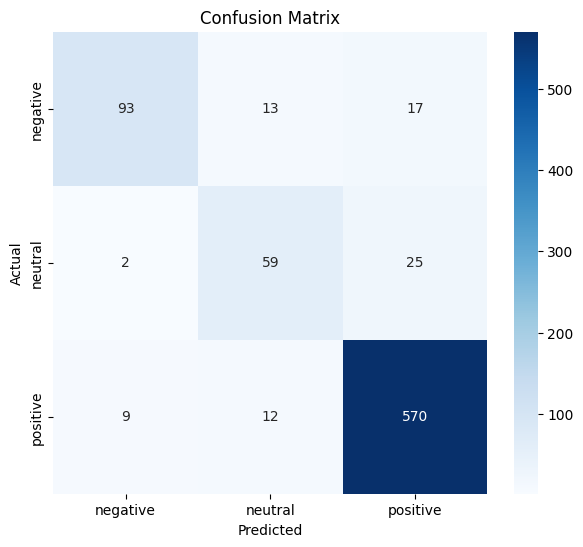

              precision    recall  f1-score   support

    negative       0.89      0.76      0.82       123
     neutral       0.70      0.69      0.69        86
    positive       0.93      0.96      0.95       591

    accuracy                           0.90       800
   macro avg       0.84      0.80      0.82       800
weighted avg       0.90      0.90      0.90       800

Accuracy Score: 0.9025


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

# 10. Evaluasi model
# Memuat model terbaik yang telah disimpan
model.load_state_dict(torch.load('best_model.pt'))

model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for batch in valid_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        all_preds.extend(logits.argmax(dim=1).cpu().numpy())
        all_true.extend(labels.cpu().numpy())

# 11. Confusion Matrix
conf_matrix = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap="Blues",
            xticklabels=label_to_id.keys(), yticklabels=label_to_id.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 12. Classification Report
report = classification_report(all_true, all_preds, target_names=label_to_id.keys())
print(report)

# 13. Accuracy Score
acc_score = accuracy_score(all_true, all_preds)
print(f"Accuracy Score: {acc_score:.4f}")

##Oversampling Negative = 500 , Epoch = 5, Learning Rate = 3e-5, Batch Size = 8, Split 80 20

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Training Loss: 0.5795, Training Acc: 0.7859, Validation Loss: 0.4762, Validation Acc: 0.8275
Epoch 2/5, Training Loss: 0.4382, Training Acc: 0.8341, Validation Loss: 0.4671, Validation Acc: 0.8475
Epoch 3/5, Training Loss: 0.3659, Training Acc: 0.8744, Validation Loss: 0.4248, Validation Acc: 0.8600
Epoch 4/5, Training Loss: 0.2981, Training Acc: 0.9006, Validation Loss: 0.3854, Validation Acc: 0.8838
Epoch 5/5, Training Loss: 0.2581, Training Acc: 0.9216, Validation Loss: 0.4041, Validation Acc: 0.8850


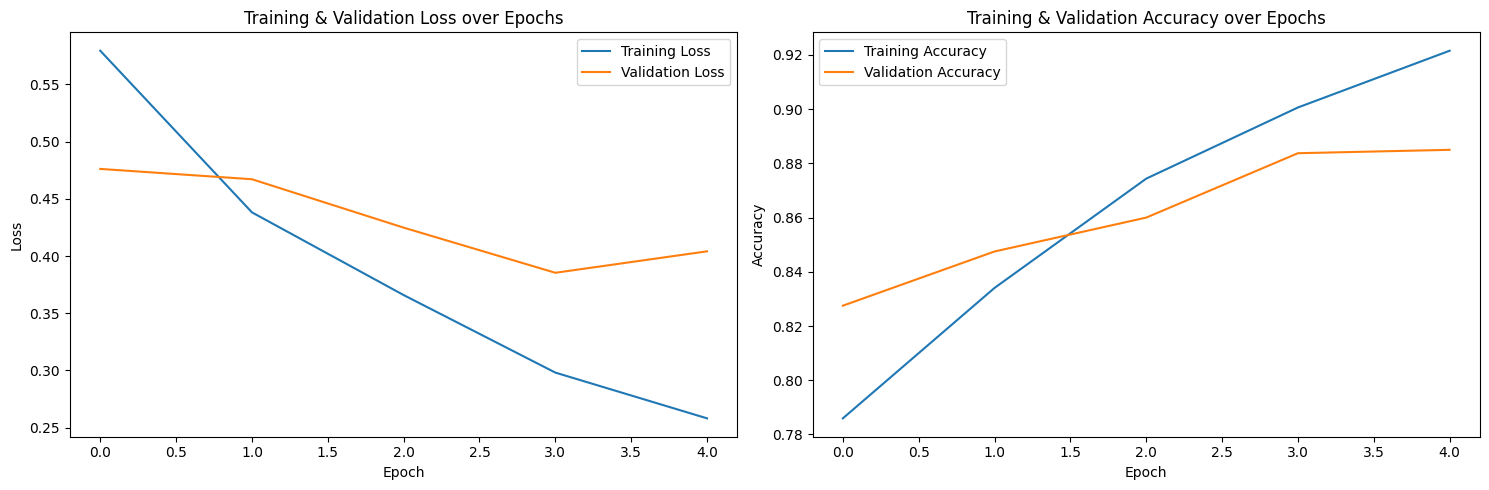

In [ ]:
import pandas as pd
import torch
from sklearn.utils import resample
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim

# 1. Memuat dataset
file_path = "/content/segari_clean_yeah_drop888.csv"
df = pd.read_csv(file_path)

# 2. Mapping score ke label
df['label'] = df['score'].apply(lambda x: 'negative' if x in [1, 2] else ('neutral' if x == 3 else 'positive'))
label_to_id = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label_id'] = df['label'].map(label_to_id)

# 3. Resampling data
# Oversampling negative class
df_negative = df[df['label'] == 'negative']
df_negative_oversampled = resample(df_negative, replace=True, n_samples=500, random_state=42)


# 4. Split resampled data menjadi 80% training dan 20% validasi
train_df, valid_df = train_test_split(df_resampled, test_size=0.2, random_state=42)

# 5. Tokenization
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
train_encodings = tokenizer(train_df['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")
valid_encodings = tokenizer(valid_df['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")

# 6. DataLoader
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(train_encodings.input_ids, train_encodings.attention_mask, torch.tensor(train_df['label_id'].tolist()))
valid_dataset = TensorDataset(valid_encodings.input_ids, valid_encodings.attention_mask, torch.tensor(valid_df['label_id'].tolist()))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

# 7. Model & Optimizer
config = BertConfig.from_pretrained("indobenchmark/indobert-base-p2", num_labels=3)
config.hidden_dropout_prob = 0.5
model = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p2", config=config)
optimizer = optim.Adam(model.parameters(), lr=3e-5)

# 7a. Tambahkan Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.1, verbose=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 8. Training Loop dengan Early Stopping dan Scheduler
num_epochs = 5
best_val_loss = float('inf')
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
n_epochs_stop = 3
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_count = 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_correct += (logits.argmax(dim=1) == labels).sum().item()
        total_count += labels.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_accs.append(total_correct / total_count)

    model.eval()
    total_val_loss = 0
    total_val_correct = 0
    total_val_count = 0

    with torch.no_grad():
        for batch in valid_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss, logits = outputs.loss, outputs.logits
            total_val_loss += loss.item()
            total_val_correct += (logits.argmax(dim=1) == labels).sum().item()
            total_val_count += labels.size(0)

    avg_val_loss = total_val_loss / len(valid_loader)
    valid_losses.append(avg_val_loss)
    valid_accs.append(total_val_correct / total_val_count)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Training Acc: {train_accs[-1]:.4f}, Validation Loss: {valid_losses[-1]:.4f}, Validation Acc: {valid_accs[-1]:.4f}")

    # Update scheduler
    scheduler.step(avg_val_loss)

    # Implementasi Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == n_epochs_stop:
            print(f"Early stopping after {epochs_no_improve} epochs!")
            break

# 9. Visualization
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss over Epochs")

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Training Accuracy")
plt.plot(valid_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy over Epochs")
plt.tight_layout()
plt.show()

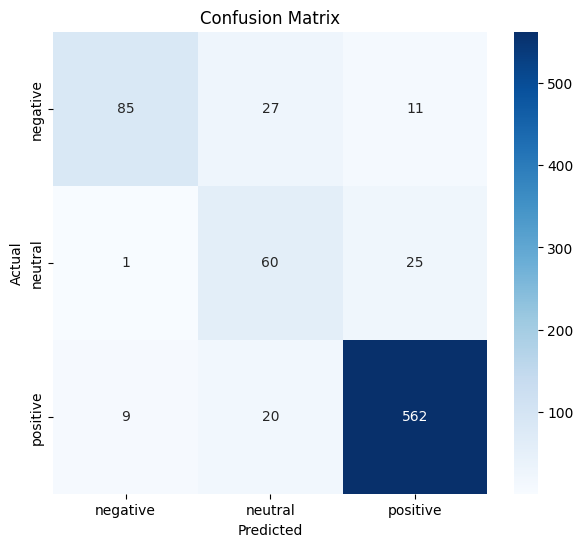

              precision    recall  f1-score   support

    negative       0.89      0.69      0.78       123
     neutral       0.56      0.70      0.62        86
    positive       0.94      0.95      0.95       591

    accuracy                           0.88       800
   macro avg       0.80      0.78      0.78       800
weighted avg       0.89      0.88      0.89       800

Accuracy Score: 0.8838


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

# 10. Evaluasi model
# Memuat model terbaik yang telah disimpan
model.load_state_dict(torch.load('best_model.pt'))

model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for batch in valid_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        all_preds.extend(logits.argmax(dim=1).cpu().numpy())
        all_true.extend(labels.cpu().numpy())

# 11. Confusion Matrix
conf_matrix = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap="Blues",
            xticklabels=label_to_id.keys(), yticklabels=label_to_id.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 12. Classification Report
report = classification_report(all_true, all_preds, target_names=label_to_id.keys())
print(report)

# 13. Accuracy Score
acc_score = accuracy_score(all_true, all_preds)
print(f"Accuracy Score: {acc_score:.4f}")

##Oversampling Negative = 500, Neutral = 500, Positif remain SAME , Epoch = 5, Learning Rate = 1e-5, Batch Size = 8, Split 80 20

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Training Loss: 0.4679, Training Acc: 0.8427, Validation Loss: 0.4349, Validation Acc: 0.8333
Epoch 2/5, Training Loss: 0.3557, Training Acc: 0.8686, Validation Loss: 0.3442, Validation Acc: 0.8798
Epoch 3/5, Training Loss: 0.3176, Training Acc: 0.8815, Validation Loss: 0.4164, Validation Acc: 0.8570
Epoch 4/5, Training Loss: 0.2853, Training Acc: 0.9032, Validation Loss: 0.3396, Validation Acc: 0.9035
Epoch 5/5, Training Loss: 0.2634, Training Acc: 0.9129, Validation Loss: 0.3353, Validation Acc: 0.9079
Test Loss: 0.3724, Test Accuracy: 0.9050


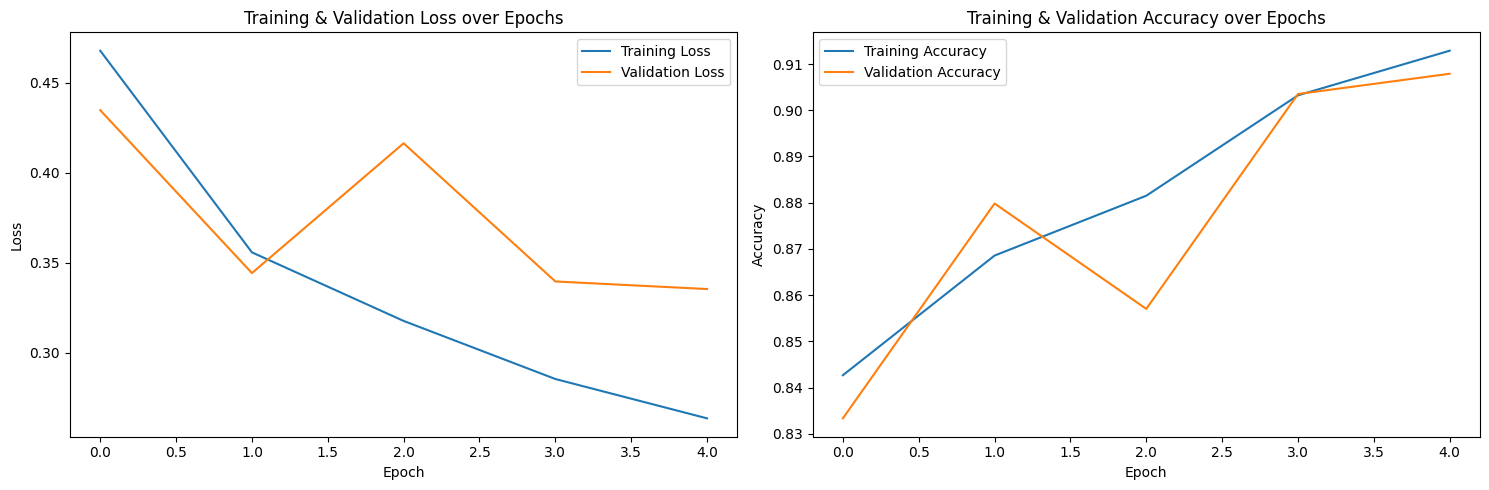

In [ ]:
import pandas as pd
import torch
from sklearn.utils import resample
from torch import optim
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. Memuat dataset
file_path = "/content/segari_clean_yeah_drop888.csv"
df = pd.read_csv(file_path)

# 2. Mapping score ke label
df['label'] = df['score'].apply(lambda x: 'negative' if x in [1, 2] else ('neutral' if x == 3 else 'positive'))

# 3. Konversi label ke id
label_to_id = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label_id'] = df['label'].map(label_to_id)

# Resampling data
target_samples = 4697

# Oversampling negative class
df_negative = df[df['label'] == 'negative']
df_negative_oversampled = resample(df_negative, replace=True, n_samples=500, random_state=42)

# Oversampling neutral class
df_neutral = df[df['label'] == 'neutral']
df_neutral_oversampled = resample(df_neutral, replace=True, n_samples=500, random_state=42)

# Using positive class as it is
df_positive = df[df['label'] == 'positive']

# Combining the resampled data
df_resampled = pd.concat([df_negative_oversampled, df_neutral_oversampled, df_positive])

# 4. Split resampled data menjadi 80% training dan 20% validation
train_df, valid_df = train_test_split(df_resampled, test_size=0.2, random_state=42)

# 5. Tokenization
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
train_encodings = tokenizer(train_df['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")
valid_encodings = tokenizer(valid_df['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")

# 6. DataLoader
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(train_encodings.input_ids, train_encodings.attention_mask, torch.tensor(train_df['label_id'].tolist()))
valid_dataset = TensorDataset(valid_encodings.input_ids, valid_encodings.attention_mask, torch.tensor(valid_df['label_id'].tolist()))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

# 7. Model & Optimizer
config = BertConfig.from_pretrained("indobenchmark/indobert-base-p2", num_labels=3)
config.hidden_dropout_prob = 0.5
model = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p2", config=config)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# 7a. Tambahkan Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.1, verbose=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 8. Training Loop dengan Early Stopping dan Scheduler
num_epochs = 5
best_val_loss = float('inf')
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
n_epochs_stop = 3
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_count = 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_correct += (logits.argmax(dim=1) == labels).sum().item()
        total_count += labels.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_accs.append(total_correct / total_count)

    model.eval()
    total_val_loss = 0
    total_val_correct = 0
    total_val_count = 0

    with torch.no_grad():
        for batch in valid_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss, logits = outputs.loss, outputs.logits
            total_val_loss += loss.item()
            total_val_correct += (logits.argmax(dim=1) == labels).sum().item()
            total_val_count += labels.size(0)

    avg_val_loss = total_val_loss / len(valid_loader)
    valid_losses.append(avg_val_loss)
    valid_accs.append(total_val_correct / total_val_count)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Training Acc: {train_accs[-1]:.4f}, Validation Loss: {valid_losses[-1]:.4f}, Validation Acc: {valid_accs[-1]:.4f}")

    # Update scheduler
    scheduler.step(avg_val_loss)

    # Implementasi Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == n_epochs_stop:
            print(f"Early stopping after {epochs_no_improve} epochs!")
            break

# Muat model dengan bobot terbaik
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

# Evaluasi pada data pengujian
total_test_correct = 0
total_test_count = 0
test_losses = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        test_losses.append(loss.item())
        total_test_correct += (logits.argmax(dim=1) == labels).sum().item()
        total_test_count += labels.size(0)

avg_test_loss = sum(test_losses) / len(test_losses)
test_accuracy = total_test_correct / total_test_count

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# 9. Visualization
# 9a. Visualisasi Loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss over Epochs")

# 9b. Visualisasi Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Training Accuracy")
plt.plot(valid_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy over Epochs")
plt.tight_layout()
plt.show()


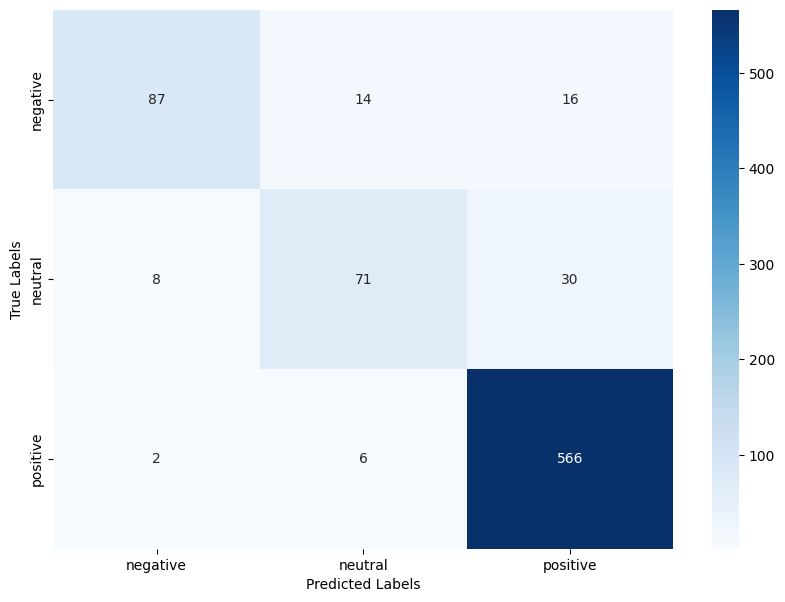

              precision    recall  f1-score   support

    negative       0.90      0.74      0.81       117
     neutral       0.78      0.65      0.71       109
    positive       0.92      0.99      0.95       574

    accuracy                           0.91       800
   macro avg       0.87      0.79      0.83       800
weighted avg       0.90      0.91      0.90       800



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 1. Prediksi Label pada Dataset Pengujian
model.eval()
all_predictions = []
all_true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = logits.argmax(dim=1).cpu().numpy()
        true_labels = labels.cpu().numpy()

        all_predictions.extend(predictions)
        all_true_labels.extend(true_labels)

# 2. Buat Confusion Matrix & Classification Report

# Confusion Matrix
cm = confusion_matrix(all_true_labels, all_predictions)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_to_id.keys(),
            yticklabels=label_to_id.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
report = classification_report(all_true_labels, all_predictions, target_names=label_to_id.keys())
print(report)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

# 10. Evaluasi model
# Memuat model terbaik yang telah disimpan
model.load_state_dict(torch.load('best_model.pt'))

model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for batch in valid_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        all_preds.extend(logits.argmax(dim=1).cpu().numpy())
        all_true.extend(labels.cpu().numpy())

# 11. Confusion Matrix
conf_matrix = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap="Blues",
            xticklabels=label_to_id.keys(), yticklabels=label_to_id.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 12. Classification Report
report = classification_report(all_true, all_preds, target_names=label_to_id.keys())
print(report)

# 13. Accuracy Score
acc_score = accuracy_score(all_true, all_preds)
print(f"Accuracy Score: {acc_score:.4f}")

##Oversampling Negative = 500, Neutral = 500, Positif remain SAME , Epoch = 5, Learning Rate = 2e-5, Batch Size = 8, Split 80 20

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Training Loss: 0.4425, Training Acc: 0.8508, Validation Loss: 0.4685, Validation Acc: 0.8412
Epoch 2/5, Training Loss: 0.3403, Training Acc: 0.8817, Validation Loss: 0.3333, Validation Acc: 0.8956
Epoch 3/5, Training Loss: 0.2942, Training Acc: 0.9041, Validation Loss: 0.3256, Validation Acc: 0.8965
Epoch 4/5, Training Loss: 0.2465, Training Acc: 0.9285, Validation Loss: 0.2929, Validation Acc: 0.9167
Epoch 5/5, Training Loss: 0.2077, Training Acc: 0.9403, Validation Loss: 0.3219, Validation Acc: 0.9193
Test Loss: 0.3126, Test Accuracy: 0.9213


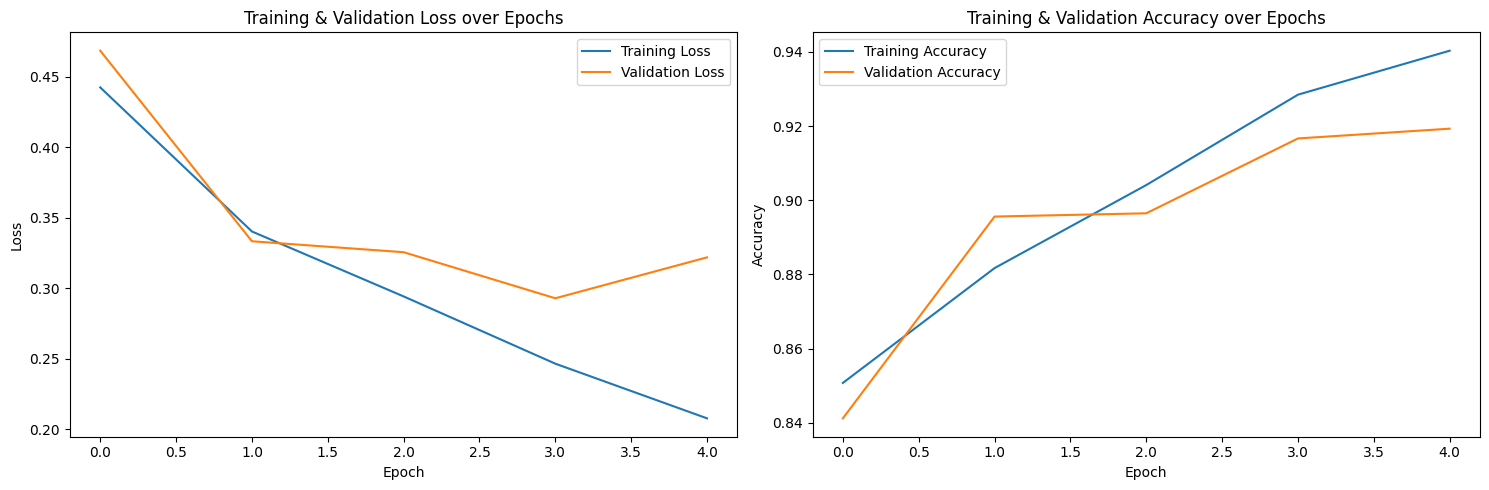

In [ ]:
import pandas as pd
import torch
from sklearn.utils import resample
from torch import optim
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. Memuat dataset
file_path = "/content/segari_clean_yeah_drop888.csv"
df = pd.read_csv(file_path)

# 2. Mapping score ke label
df['label'] = df['score'].apply(lambda x: 'negative' if x in [1, 2] else ('neutral' if x == 3 else 'positive'))

# 3. Konversi label ke id
label_to_id = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label_id'] = df['label'].map(label_to_id)

# Resampling data
target_samples = 4697

# Oversampling negative class
df_negative = df[df['label'] == 'negative']
df_negative_oversampled = resample(df_negative, replace=True, n_samples=500, random_state=42)

# Oversampling neutral class
df_neutral = df[df['label'] == 'neutral']
df_neutral_oversampled = resample(df_neutral, replace=True, n_samples=500, random_state=42)

# Using positive class as it is
df_positive = df[df['label'] == 'positive']

# Combining the resampled data
df_resampled = pd.concat([df_negative_oversampled, df_neutral_oversampled, df_positive])

# 4. Split resampled data menjadi 80% training dan 20% validation
train_df, valid_df = train_test_split(df_resampled, test_size=0.2, random_state=42)

# 5. Tokenization
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
train_encodings = tokenizer(train_df['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")
valid_encodings = tokenizer(valid_df['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")

# 6. DataLoader
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(train_encodings.input_ids, train_encodings.attention_mask, torch.tensor(train_df['label_id'].tolist()))
valid_dataset = TensorDataset(valid_encodings.input_ids, valid_encodings.attention_mask, torch.tensor(valid_df['label_id'].tolist()))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

# 7. Model & Optimizer
config = BertConfig.from_pretrained("indobenchmark/indobert-base-p2", num_labels=3)
config.hidden_dropout_prob = 0.5
model = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p2", config=config)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

# 7a. Tambahkan Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.1, verbose=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 8. Training Loop dengan Early Stopping dan Scheduler
num_epochs = 5
best_val_loss = float('inf')
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
n_epochs_stop = 3
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_count = 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_correct += (logits.argmax(dim=1) == labels).sum().item()
        total_count += labels.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_accs.append(total_correct / total_count)

    model.eval()
    total_val_loss = 0
    total_val_correct = 0
    total_val_count = 0

    with torch.no_grad():
        for batch in valid_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss, logits = outputs.loss, outputs.logits
            total_val_loss += loss.item()
            total_val_correct += (logits.argmax(dim=1) == labels).sum().item()
            total_val_count += labels.size(0)

    avg_val_loss = total_val_loss / len(valid_loader)
    valid_losses.append(avg_val_loss)
    valid_accs.append(total_val_correct / total_val_count)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Training Acc: {train_accs[-1]:.4f}, Validation Loss: {valid_losses[-1]:.4f}, Validation Acc: {valid_accs[-1]:.4f}")

    # Update scheduler
    scheduler.step(avg_val_loss)

    # Implementasi Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == n_epochs_stop:
            print(f"Early stopping after {epochs_no_improve} epochs!")
            break

# Muat model dengan bobot terbaik
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

# Evaluasi pada data pengujian
total_test_correct = 0
total_test_count = 0
test_losses = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        test_losses.append(loss.item())
        total_test_correct += (logits.argmax(dim=1) == labels).sum().item()
        total_test_count += labels.size(0)

avg_test_loss = sum(test_losses) / len(test_losses)
test_accuracy = total_test_correct / total_test_count

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# 9. Visualization
# 9a. Visualisasi Loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss over Epochs")

# 9b. Visualisasi Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Training Accuracy")
plt.plot(valid_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy over Epochs")
plt.tight_layout()
plt.show()

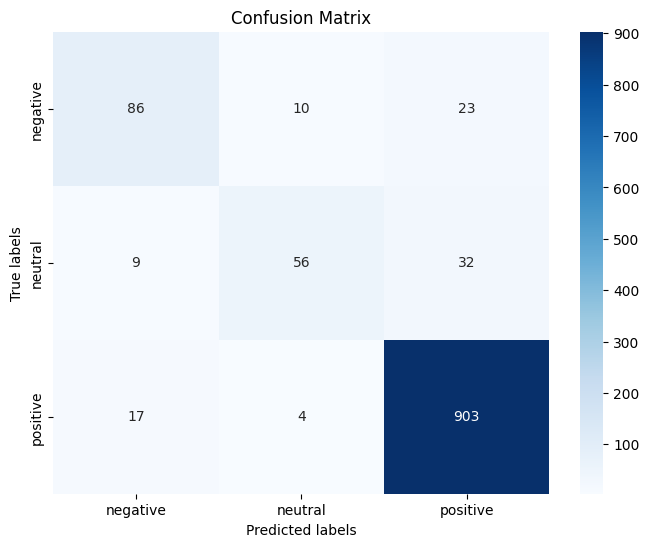

              precision    recall  f1-score   support

    negative       0.77      0.72      0.74       119
     neutral       0.80      0.58      0.67        97
    positive       0.94      0.98      0.96       924

    accuracy                           0.92      1140
   macro avg       0.84      0.76      0.79      1140
weighted avg       0.91      0.92      0.91      1140



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Prediksi label pada data pengujian
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in valid_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        all_preds.extend(logits.argmax(dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Menghitung confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Visualisasi confusion matrix dengan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues',
            xticklabels=label_to_id.keys(),
            yticklabels=label_to_id.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Menghitung dan menampilkan classification report
report = classification_report(all_labels, all_preds, target_names=label_to_id.keys())
print(report)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

# 10. Evaluasi model
# Memuat model terbaik yang telah disimpan
model.load_state_dict(torch.load('best_model.pt'))

model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for batch in valid_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        all_preds.extend(logits.argmax(dim=1).cpu().numpy())
        all_true.extend(labels.cpu().numpy())

# 11. Confusion Matrix
conf_matrix = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap="Blues",
            xticklabels=label_to_id.keys(), yticklabels=label_to_id.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 12. Classification Report
report = classification_report(all_true, all_preds, target_names=label_to_id.keys())
print(report)

# 13. Accuracy Score
acc_score = accuracy_score(all_true, all_preds)
print(f"Accuracy Score: {acc_score:.4f}")

##Oversampling Negative = 500, Neutral = 500, Positif remain SAME , Epoch = 5, Learning Rate = 3e-5, Batch Size = 8, Split 80 20

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Training Loss: 0.4497, Training Acc: 0.8444, Validation Loss: 0.3953, Validation Acc: 0.8658
Epoch 2/5, Training Loss: 0.3557, Training Acc: 0.8765, Validation Loss: 0.4239, Validation Acc: 0.8605
Epoch 3/5, Training Loss: 0.3047, Training Acc: 0.8929, Validation Loss: 0.4183, Validation Acc: 0.8781
Epoch 00003: reducing learning rate of group 0 to 3.0000e-06.
Epoch 4/5, Training Loss: 0.2514, Training Acc: 0.9164, Validation Loss: 0.3779, Validation Acc: 0.8912
Epoch 5/5, Training Loss: 0.2346, Training Acc: 0.9276, Validation Loss: 0.3959, Validation Acc: 0.8982
Test Loss: 0.3944, Test Accuracy: 0.8912


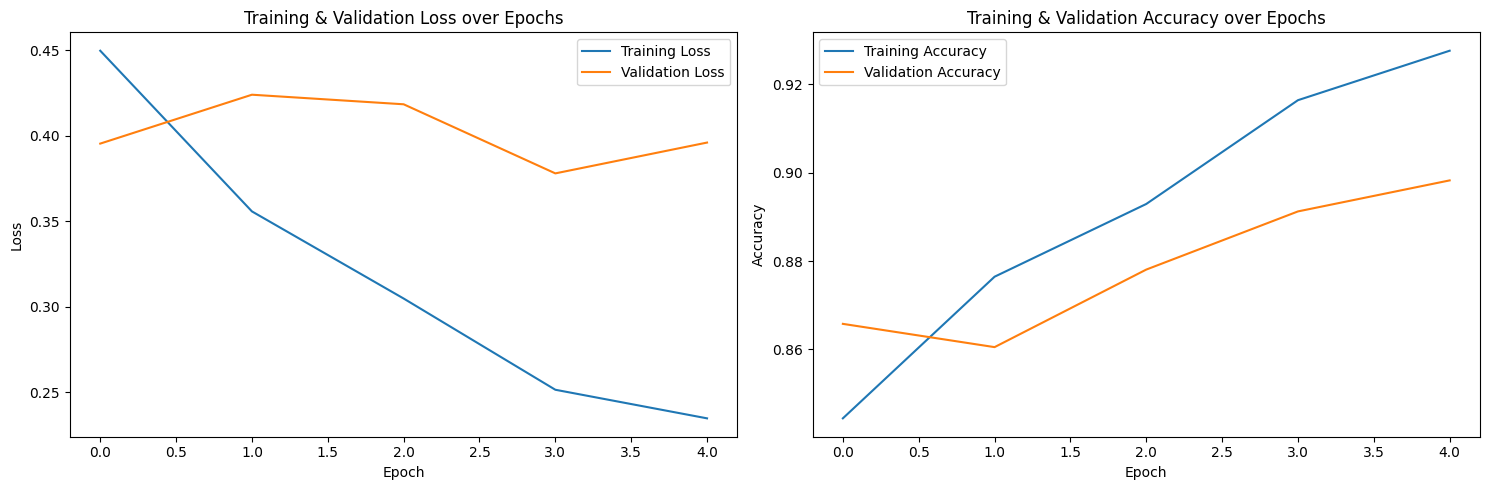

In [ ]:
import pandas as pd
import torch
from sklearn.utils import resample
from torch import optim
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. Memuat dataset
file_path = "/content/segari_clean_yeah_drop888.csv"
df = pd.read_csv(file_path)

# 2. Mapping score ke label
df['label'] = df['score'].apply(lambda x: 'negative' if x in [1, 2] else ('neutral' if x == 3 else 'positive'))

# 3. Konversi label ke id
label_to_id = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label_id'] = df['label'].map(label_to_id)

# Resampling data
target_samples = 4697

# Oversampling negative class
df_negative = df[df['label'] == 'negative']
df_negative_oversampled = resample(df_negative, replace=True, n_samples=500, random_state=42)

# Oversampling neutral class
df_neutral = df[df['label'] == 'neutral']
df_neutral_oversampled = resample(df_neutral, replace=True, n_samples=500, random_state=42)

# Using positive class as it is
df_positive = df[df['label'] == 'positive']

# Combining the resampled data
df_resampled = pd.concat([df_negative_oversampled, df_neutral_oversampled, df_positive])

# 4. Split resampled data menjadi 80% training dan 20% validation
train_df, valid_df = train_test_split(df_resampled, test_size=0.2, random_state=42)

# 5. Tokenization
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
train_encodings = tokenizer(train_df['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")
valid_encodings = tokenizer(valid_df['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")

# 6. DataLoader
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(train_encodings.input_ids, train_encodings.attention_mask, torch.tensor(train_df['label_id'].tolist()))
valid_dataset = TensorDataset(valid_encodings.input_ids, valid_encodings.attention_mask, torch.tensor(valid_df['label_id'].tolist()))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

# 7. Model & Optimizer
config = BertConfig.from_pretrained("indobenchmark/indobert-base-p2", num_labels=3)
config.hidden_dropout_prob = 0.5
model = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p2", config=config)
optimizer = optim.Adam(model.parameters(), lr=3e-5)

# 7a. Tambahkan Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.1, verbose=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 8. Training Loop dengan Early Stopping dan Scheduler
num_epochs = 5
best_val_loss = float('inf')
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
n_epochs_stop = 3
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_count = 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_correct += (logits.argmax(dim=1) == labels).sum().item()
        total_count += labels.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_accs.append(total_correct / total_count)

    model.eval()
    total_val_loss = 0
    total_val_correct = 0
    total_val_count = 0

    with torch.no_grad():
        for batch in valid_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss, logits = outputs.loss, outputs.logits
            total_val_loss += loss.item()
            total_val_correct += (logits.argmax(dim=1) == labels).sum().item()
            total_val_count += labels.size(0)

    avg_val_loss = total_val_loss / len(valid_loader)
    valid_losses.append(avg_val_loss)
    valid_accs.append(total_val_correct / total_val_count)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Training Acc: {train_accs[-1]:.4f}, Validation Loss: {valid_losses[-1]:.4f}, Validation Acc: {valid_accs[-1]:.4f}")

    # Update scheduler
    scheduler.step(avg_val_loss)

    # Implementasi Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == n_epochs_stop:
            print(f"Early stopping after {epochs_no_improve} epochs!")
            break

# Muat model dengan bobot terbaik
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

# Evaluasi pada data pengujian
total_test_correct = 0
total_test_count = 0
test_losses = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        test_losses.append(loss.item())
        total_test_correct += (logits.argmax(dim=1) == labels).sum().item()
        total_test_count += labels.size(0)

avg_test_loss = sum(test_losses) / len(test_losses)
test_accuracy = total_test_correct / total_test_count

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# 9. Visualization
# 9a. Visualisasi Loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss over Epochs")

# 9b. Visualisasi Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Training Accuracy")
plt.plot(valid_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy over Epochs")
plt.tight_layout()
plt.show()

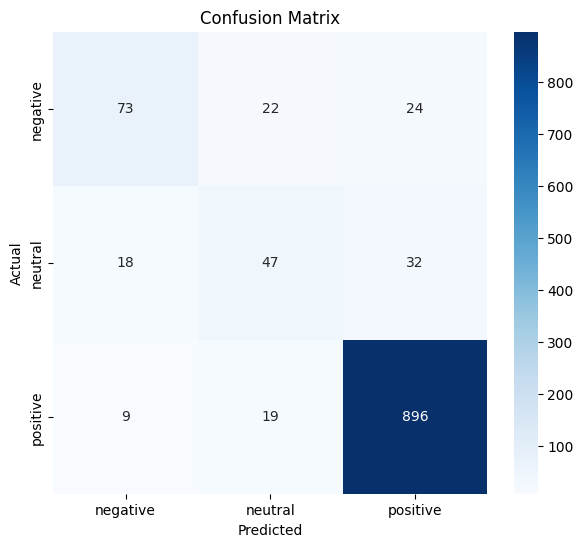

              precision    recall  f1-score   support

    negative       0.73      0.61      0.67       119
     neutral       0.53      0.48      0.51        97
    positive       0.94      0.97      0.96       924

    accuracy                           0.89      1140
   macro avg       0.74      0.69      0.71      1140
weighted avg       0.88      0.89      0.89      1140

Accuracy Score: 0.8912


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

# 10. Evaluasi model
# Memuat model terbaik yang telah disimpan
model.load_state_dict(torch.load('best_model.pt'))

model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for batch in valid_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        all_preds.extend(logits.argmax(dim=1).cpu().numpy())
        all_true.extend(labels.cpu().numpy())

# 11. Confusion Matrix
conf_matrix = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap="Blues",
            xticklabels=label_to_id.keys(), yticklabels=label_to_id.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 12. Classification Report
report = classification_report(all_true, all_preds, target_names=label_to_id.keys())
print(report)

# 13. Accuracy Score
acc_score = accuracy_score(all_true, all_preds)
print(f"Accuracy Score: {acc_score:.4f}")

##Oversampling Negative = 500, Neutral = 500, Undersampling Positif = 3000, Epoch = 5, Learning Rate = 1e-5, Batch Size = 8, Split 80 20

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Training Loss: 0.5797, Training Acc: 0.7869, Validation Loss: 0.6221, Validation Acc: 0.8013
Epoch 2/5, Training Loss: 0.4640, Training Acc: 0.8237, Validation Loss: 0.4854, Validation Acc: 0.8225
Epoch 3/5, Training Loss: 0.3991, Training Acc: 0.8550, Validation Loss: 0.4344, Validation Acc: 0.8413
Epoch 4/5, Training Loss: 0.3666, Training Acc: 0.8647, Validation Loss: 0.4425, Validation Acc: 0.8538
Epoch 5/5, Training Loss: 0.3275, Training Acc: 0.8850, Validation Loss: 0.3897, Validation Acc: 0.8775
Test Loss: 0.3540, Test Accuracy: 0.8850


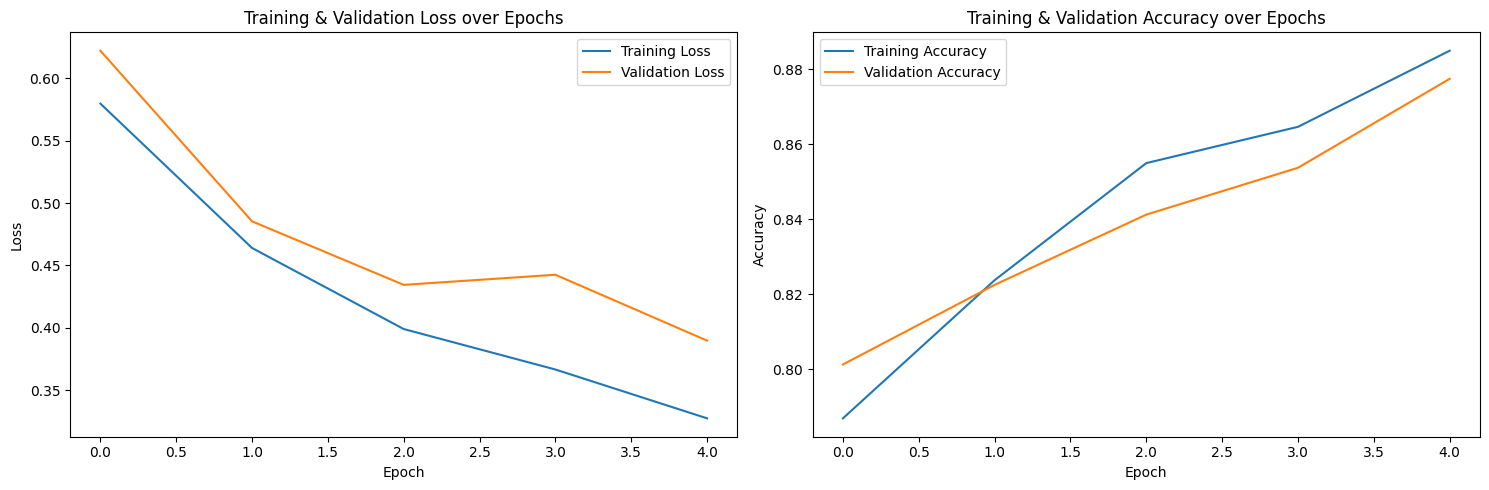

In [ ]:
import pandas as pd
import torch
import torch.optim as optim
from sklearn.utils import resample
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. Memuat dataset
file_path = "/content/segari_clean_yeah_drop888.csv"
df = pd.read_csv(file_path)

# 2. Mapping score ke label
df['label'] = df['score'].apply(lambda x: 'negative' if x in [1, 2] else ('neutral' if x == 3 else 'positive'))
label_to_id = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label_id'] = df['label'].map(label_to_id)

# 3. Resampling data
df_negative = df[df['label'] == 'negative']
df_negative_oversampled = resample(df_negative, replace=True, n_samples=500, random_state=42)

df_neutral = df[df['label'] == 'neutral']
df_neutral_oversampled = resample(df_neutral, replace=True, n_samples=500, random_state=42)

df_positive = df[df['label'] == 'positive']
df_positive_undersampled = resample(df_positive, replace=False, n_samples=3000, random_state=42)

df_resampled = pd.concat([df_negative_oversampled, df_neutral_oversampled, df_positive_undersampled])

# 4. Split resampled data dengan rasio 80-20 untuk training-validasi
train_df, valid_df = train_test_split(df_resampled, test_size=0.2, random_state=42)

# 5. Tokenization
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
train_encodings = tokenizer(train_df['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")
valid_encodings = tokenizer(valid_df['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")

# 6. DataLoader
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(train_encodings.input_ids, train_encodings.attention_mask, torch.tensor(train_df['label_id'].tolist()))
valid_dataset = TensorDataset(valid_encodings.input_ids, valid_encodings.attention_mask, torch.tensor(valid_df['label_id'].tolist()))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

# 7. Model & Optimizer
config = BertConfig.from_pretrained("indobenchmark/indobert-base-p2", num_labels=3)
config.hidden_dropout_prob = 0.5
model = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p2", config=config)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# 7a. Tambahkan Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.1, verbose=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 8. Training Loop dengan Early Stopping dan Scheduler
num_epochs = 5
best_val_loss = float('inf')
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
n_epochs_stop = 3
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_count = 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_correct += (logits.argmax(dim=1) == labels).sum().item()
        total_count += labels.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_accs.append(total_correct / total_count)

    model.eval()
    total_val_loss = 0
    total_val_correct = 0
    total_val_count = 0

    with torch.no_grad():
        for batch in valid_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss, logits = outputs.loss, outputs.logits
            total_val_loss += loss.item()
            total_val_correct += (logits.argmax(dim=1) == labels).sum().item()
            total_val_count += labels.size(0)

    avg_val_loss = total_val_loss / len(valid_loader)
    valid_losses.append(avg_val_loss)
    valid_accs.append(total_val_correct / total_val_count)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Training Acc: {train_accs[-1]:.4f}, Validation Loss: {valid_losses[-1]:.4f}, Validation Acc: {valid_accs[-1]:.4f}")

    # Update scheduler
    scheduler.step(avg_val_loss)

    # Implementasi Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == n_epochs_stop:
            print(f"Early stopping after {epochs_no_improve} epochs!")
            break

# Muat model dengan bobot terbaik
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

# Evaluasi pada data pengujian
total_test_correct = 0
total_test_count = 0
test_losses = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        test_losses.append(loss.item())
        total_test_correct += (logits.argmax(dim=1) == labels).sum().item()
        total_test_count += labels.size(0)

avg_test_loss = sum(test_losses) / len(test_losses)
test_accuracy = total_test_correct / total_test_count

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# 9. Visualization
# 9a. Visualisasi Loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss over Epochs")

# 9b. Visualisasi Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Training Accuracy")
plt.plot(valid_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy over Epochs")
plt.tight_layout()
plt.show()

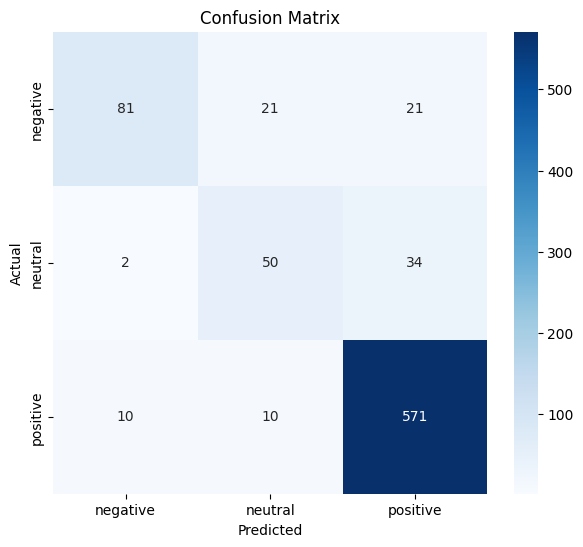

              precision    recall  f1-score   support

    negative       0.87      0.66      0.75       123
     neutral       0.62      0.58      0.60        86
    positive       0.91      0.97      0.94       591

    accuracy                           0.88       800
   macro avg       0.80      0.74      0.76       800
weighted avg       0.87      0.88      0.87       800

Accuracy Score: 0.8775


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

# 10. Evaluasi model
# Memuat model terbaik yang telah disimpan
model.load_state_dict(torch.load('best_model.pt'))

model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for batch in valid_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        all_preds.extend(logits.argmax(dim=1).cpu().numpy())
        all_true.extend(labels.cpu().numpy())

# 11. Confusion Matrix
conf_matrix = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap="Blues",
            xticklabels=label_to_id.keys(), yticklabels=label_to_id.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 12. Classification Report
report = classification_report(all_true, all_preds, target_names=label_to_id.keys())
print(report)

# 13. Accuracy Score
acc_score = accuracy_score(all_true, all_preds)
print(f"Accuracy Score: {acc_score:.4f}")

##Oversampling Negative = 500, Neutral = 500, Undersampling Positif = 3000, Epoch = 5, Learning Rate = 2e-5, Batch Size = 8, Split 80 20

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Training Loss: 0.5718, Training Acc: 0.7866, Validation Loss: 0.5910, Validation Acc: 0.8100
Epoch 2/5, Training Loss: 0.4587, Training Acc: 0.8341, Validation Loss: 0.5327, Validation Acc: 0.8225
Epoch 3/5, Training Loss: 0.3933, Training Acc: 0.8609, Validation Loss: 0.4059, Validation Acc: 0.8550
Epoch 4/5, Training Loss: 0.3342, Training Acc: 0.8878, Validation Loss: 0.3582, Validation Acc: 0.8788
Epoch 5/5, Training Loss: 0.2901, Training Acc: 0.9109, Validation Loss: 0.3775, Validation Acc: 0.8900
Test Loss: 0.3148, Test Accuracy: 0.8975


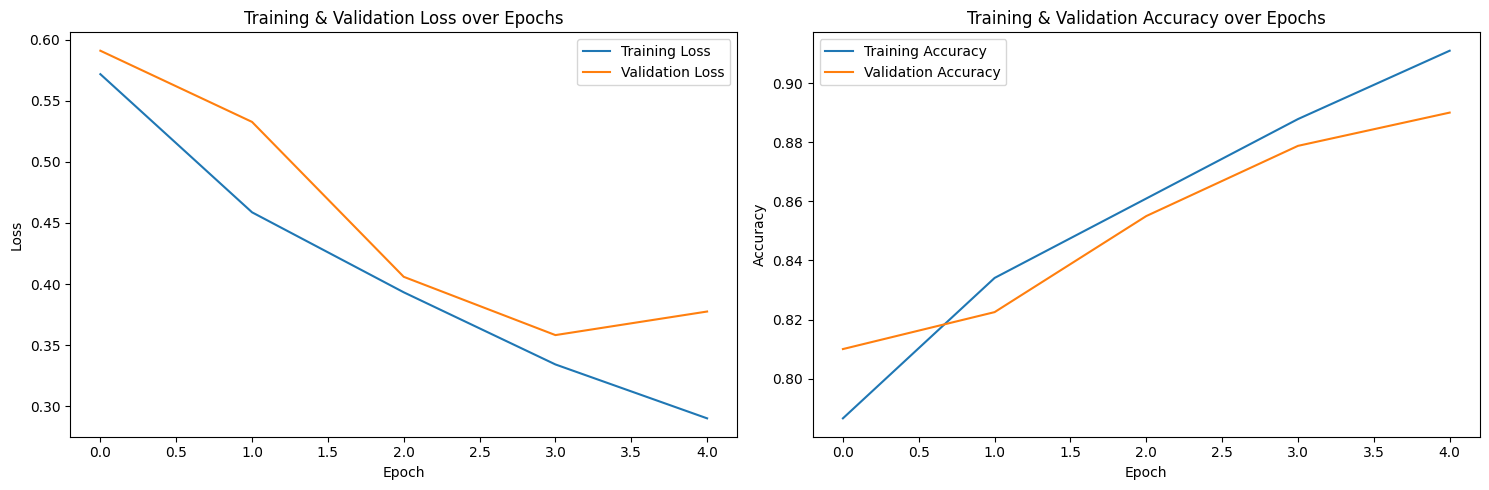

In [ ]:
import pandas as pd
import torch
import torch.optim as optim
from sklearn.utils import resample
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. Memuat dataset
file_path = "/content/segari_clean_yeah_drop888.csv"
df = pd.read_csv(file_path)

# 2. Mapping score ke label
df['label'] = df['score'].apply(lambda x: 'negative' if x in [1, 2] else ('neutral' if x == 3 else 'positive'))
label_to_id = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label_id'] = df['label'].map(label_to_id)

# 3. Resampling data
df_negative = df[df['label'] == 'negative']
df_negative_oversampled = resample(df_negative, replace=True, n_samples=500, random_state=42)

df_neutral = df[df['label'] == 'neutral']
df_neutral_oversampled = resample(df_neutral, replace=True, n_samples=500, random_state=42)

df_positive = df[df['label'] == 'positive']
df_positive_undersampled = resample(df_positive, replace=False, n_samples=3000, random_state=42)

df_resampled = pd.concat([df_negative_oversampled, df_neutral_oversampled, df_positive_undersampled])

# 4. Split resampled data dengan rasio 80-20 untuk training-validasi
train_df, valid_df = train_test_split(df_resampled, test_size=0.2, random_state=42)

# 5. Tokenization
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
train_encodings = tokenizer(train_df['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")
valid_encodings = tokenizer(valid_df['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")

# 6. DataLoader
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(train_encodings.input_ids, train_encodings.attention_mask, torch.tensor(train_df['label_id'].tolist()))
valid_dataset = TensorDataset(valid_encodings.input_ids, valid_encodings.attention_mask, torch.tensor(valid_df['label_id'].tolist()))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

# 7. Model & Optimizer
config = BertConfig.from_pretrained("indobenchmark/indobert-base-p2", num_labels=3)
config.hidden_dropout_prob = 0.5
model = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p2", config=config)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

# 7a. Tambahkan Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.1, verbose=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 8. Training Loop dengan Early Stopping dan Scheduler
num_epochs = 5
best_val_loss = float('inf')
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
n_epochs_stop = 3
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_count = 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_correct += (logits.argmax(dim=1) == labels).sum().item()
        total_count += labels.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_accs.append(total_correct / total_count)

    model.eval()
    total_val_loss = 0
    total_val_correct = 0
    total_val_count = 0

    with torch.no_grad():
        for batch in valid_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss, logits = outputs.loss, outputs.logits
            total_val_loss += loss.item()
            total_val_correct += (logits.argmax(dim=1) == labels).sum().item()
            total_val_count += labels.size(0)

    avg_val_loss = total_val_loss / len(valid_loader)
    valid_losses.append(avg_val_loss)
    valid_accs.append(total_val_correct / total_val_count)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Training Acc: {train_accs[-1]:.4f}, Validation Loss: {valid_losses[-1]:.4f}, Validation Acc: {valid_accs[-1]:.4f}")

    # Update scheduler
    scheduler.step(avg_val_loss)

    # Implementasi Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == n_epochs_stop:
            print(f"Early stopping after {epochs_no_improve} epochs!")
            break

# Muat model dengan bobot terbaik
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

# Evaluasi pada data pengujian
total_test_correct = 0
total_test_count = 0
test_losses = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        test_losses.append(loss.item())
        total_test_correct += (logits.argmax(dim=1) == labels).sum().item()
        total_test_count += labels.size(0)

avg_test_loss = sum(test_losses) / len(test_losses)
test_accuracy = total_test_correct / total_test_count

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# 9. Visualization
# 9a. Visualisasi Loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss over Epochs")

# 9b. Visualisasi Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Training Accuracy")
plt.plot(valid_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy over Epochs")
plt.tight_layout()
plt.show()

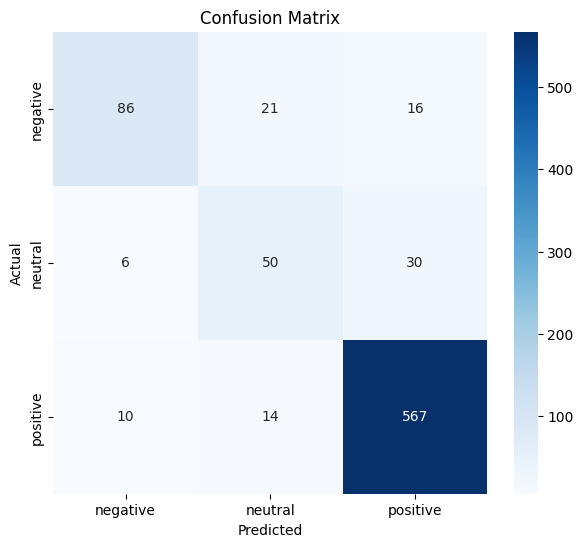

              precision    recall  f1-score   support

    negative       0.84      0.70      0.76       123
     neutral       0.59      0.58      0.58        86
    positive       0.92      0.96      0.94       591

    accuracy                           0.88       800
   macro avg       0.79      0.75      0.76       800
weighted avg       0.88      0.88      0.88       800

Accuracy Score: 0.8788


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

# 10. Evaluasi model
# Memuat model terbaik yang telah disimpan
model.load_state_dict(torch.load('best_model.pt'))

model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for batch in valid_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        all_preds.extend(logits.argmax(dim=1).cpu().numpy())
        all_true.extend(labels.cpu().numpy())

# 11. Confusion Matrix
conf_matrix = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap="Blues",
            xticklabels=label_to_id.keys(), yticklabels=label_to_id.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 12. Classification Report
report = classification_report(all_true, all_preds, target_names=label_to_id.keys())
print(report)

# 13. Accuracy Score
acc_score = accuracy_score(all_true, all_preds)
print(f"Accuracy Score: {acc_score:.4f}")

##Oversampling Negative = 500, Neutral = 500, Undersampling Positif = 3000, Epoch = 5, Learning Rate = 3e-5, Batch Size = 8, Split 80 20

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Training Loss: 0.5768, Training Acc: 0.7847, Validation Loss: 0.4751, Validation Acc: 0.8337
Epoch 2/5, Training Loss: 0.4493, Training Acc: 0.8275, Validation Loss: 0.4482, Validation Acc: 0.8300
Epoch 3/5, Training Loss: 0.3932, Training Acc: 0.8612, Validation Loss: 0.4224, Validation Acc: 0.8600
Epoch 4/5, Training Loss: 0.3482, Training Acc: 0.8881, Validation Loss: 0.4441, Validation Acc: 0.8575
Epoch 5/5, Training Loss: 0.3225, Training Acc: 0.9066, Validation Loss: 0.3905, Validation Acc: 0.8888
Test Loss: 0.3521, Test Accuracy: 0.8962


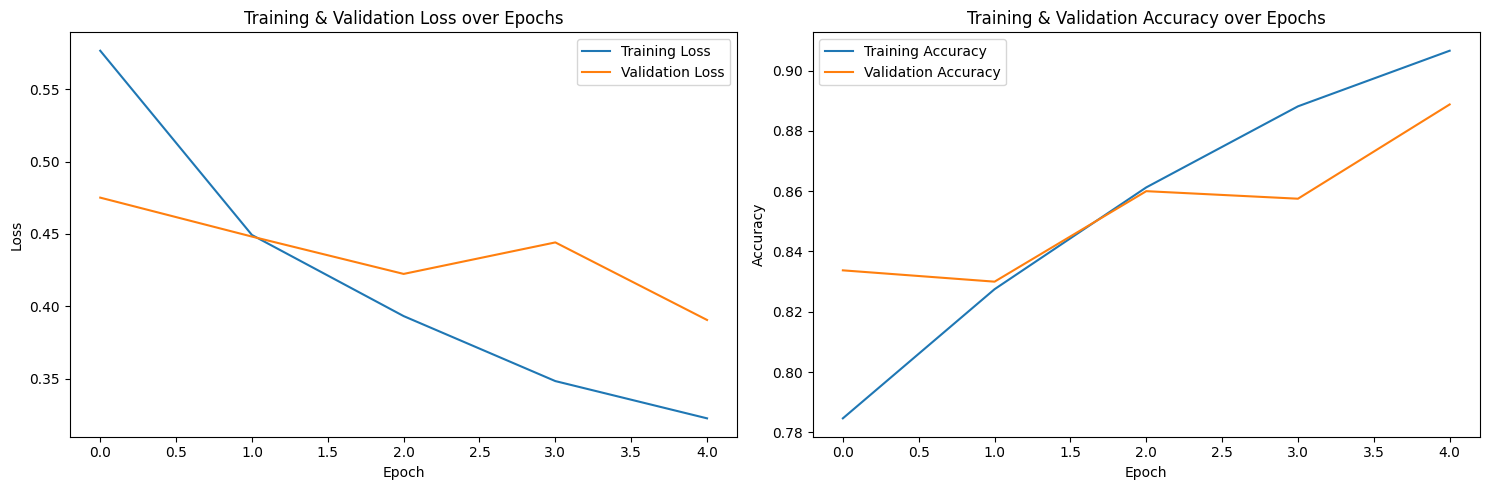

In [ ]:
import pandas as pd
import torch
import torch.optim as optim
from sklearn.utils import resample
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. Memuat dataset
file_path = "/content/segari_clean_yeah_drop888.csv"
df = pd.read_csv(file_path)

# 2. Mapping score ke label
df['label'] = df['score'].apply(lambda x: 'negative' if x in [1, 2] else ('neutral' if x == 3 else 'positive'))
label_to_id = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label_id'] = df['label'].map(label_to_id)

# 3. Resampling data
df_negative = df[df['label'] == 'negative']
df_negative_oversampled = resample(df_negative, replace=True, n_samples=500, random_state=42)

df_neutral = df[df['label'] == 'neutral']
df_neutral_oversampled = resample(df_neutral, replace=True, n_samples=500, random_state=42)

df_positive = df[df['label'] == 'positive']
df_positive_undersampled = resample(df_positive, replace=False, n_samples=3000, random_state=42)

df_resampled = pd.concat([df_negative_oversampled, df_neutral_oversampled, df_positive_undersampled])

# 4. Split resampled data dengan rasio 80-20 untuk training-validasi
train_df, valid_df = train_test_split(df_resampled, test_size=0.2, random_state=42)

# 5. Tokenization
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
train_encodings = tokenizer(train_df['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")
valid_encodings = tokenizer(valid_df['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")

# 6. DataLoader
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(train_encodings.input_ids, train_encodings.attention_mask, torch.tensor(train_df['label_id'].tolist()))
valid_dataset = TensorDataset(valid_encodings.input_ids, valid_encodings.attention_mask, torch.tensor(valid_df['label_id'].tolist()))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

# 7. Model & Optimizer
config = BertConfig.from_pretrained("indobenchmark/indobert-base-p2", num_labels=3)
config.hidden_dropout_prob = 0.5
model = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p2", config=config)
optimizer = optim.Adam(model.parameters(), lr=3e-5)

# 7a. Tambahkan Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.1, verbose=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 8. Training Loop dengan Early Stopping dan Scheduler
num_epochs = 5
best_val_loss = float('inf')
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
n_epochs_stop = 3
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_count = 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_correct += (logits.argmax(dim=1) == labels).sum().item()
        total_count += labels.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_accs.append(total_correct / total_count)

    model.eval()
    total_val_loss = 0
    total_val_correct = 0
    total_val_count = 0

    with torch.no_grad():
        for batch in valid_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss, logits = outputs.loss, outputs.logits
            total_val_loss += loss.item()
            total_val_correct += (logits.argmax(dim=1) == labels).sum().item()
            total_val_count += labels.size(0)

    avg_val_loss = total_val_loss / len(valid_loader)
    valid_losses.append(avg_val_loss)
    valid_accs.append(total_val_correct / total_val_count)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Training Acc: {train_accs[-1]:.4f}, Validation Loss: {valid_losses[-1]:.4f}, Validation Acc: {valid_accs[-1]:.4f}")

    # Update scheduler
    scheduler.step(avg_val_loss)

    # Implementasi Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == n_epochs_stop:
            print(f"Early stopping after {epochs_no_improve} epochs!")
            break

# Muat model dengan bobot terbaik
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

# Evaluasi pada data pengujian
total_test_correct = 0
total_test_count = 0
test_losses = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        test_losses.append(loss.item())
        total_test_correct += (logits.argmax(dim=1) == labels).sum().item()
        total_test_count += labels.size(0)

avg_test_loss = sum(test_losses) / len(test_losses)
test_accuracy = total_test_correct / total_test_count

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# 9. Visualization
# 9a. Visualisasi Loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss over Epochs")

# 9b. Visualisasi Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Training Accuracy")
plt.plot(valid_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy over Epochs")
plt.tight_layout()
plt.show()

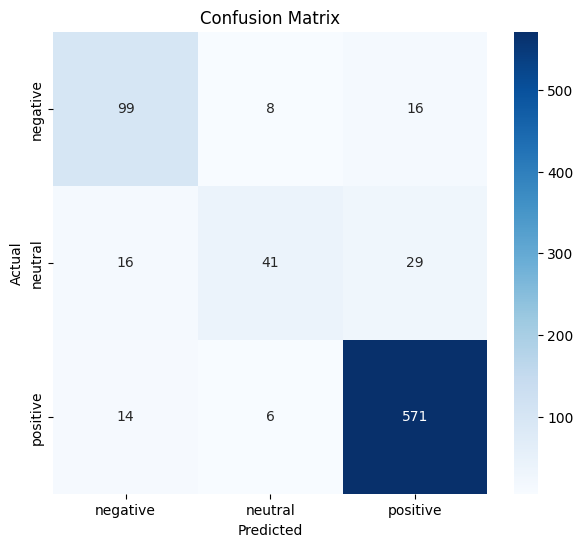

              precision    recall  f1-score   support

    negative       0.77      0.80      0.79       123
     neutral       0.75      0.48      0.58        86
    positive       0.93      0.97      0.95       591

    accuracy                           0.89       800
   macro avg       0.81      0.75      0.77       800
weighted avg       0.88      0.89      0.88       800

Accuracy Score: 0.8888


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

# 10. Evaluasi model
# Memuat model terbaik yang telah disimpan
model.load_state_dict(torch.load('best_model.pt'))

model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for batch in valid_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        all_preds.extend(logits.argmax(dim=1).cpu().numpy())
        all_true.extend(labels.cpu().numpy())

# 11. Confusion Matrix
conf_matrix = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap="Blues",
            xticklabels=label_to_id.keys(), yticklabels=label_to_id.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 12. Classification Report
report = classification_report(all_true, all_preds, target_names=label_to_id.keys())
print(report)

# 13. Accuracy Score
acc_score = accuracy_score(all_true, all_preds)
print(f"Accuracy Score: {acc_score:.4f}")

##Oversampling Negative = 500, Neutral = 500, Undersampling Positif = 3000, Epoch = 5, Learning Rate = 1e-5, Batch Size = 16, Split 80 20

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Training Loss: 0.6069, Training Acc: 0.7747, Validation Loss: 0.5825, Validation Acc: 0.7975
Epoch 2/5, Training Loss: 0.4689, Training Acc: 0.8219, Validation Loss: 0.4905, Validation Acc: 0.8163
Epoch 3/5, Training Loss: 0.4281, Training Acc: 0.8438, Validation Loss: 0.4417, Validation Acc: 0.8488
Epoch 4/5, Training Loss: 0.3713, Training Acc: 0.8650, Validation Loss: 0.4325, Validation Acc: 0.8612
Epoch 5/5, Training Loss: 0.3455, Training Acc: 0.8728, Validation Loss: 0.3935, Validation Acc: 0.8700
Test Loss: 0.3603, Test Accuracy: 0.8712


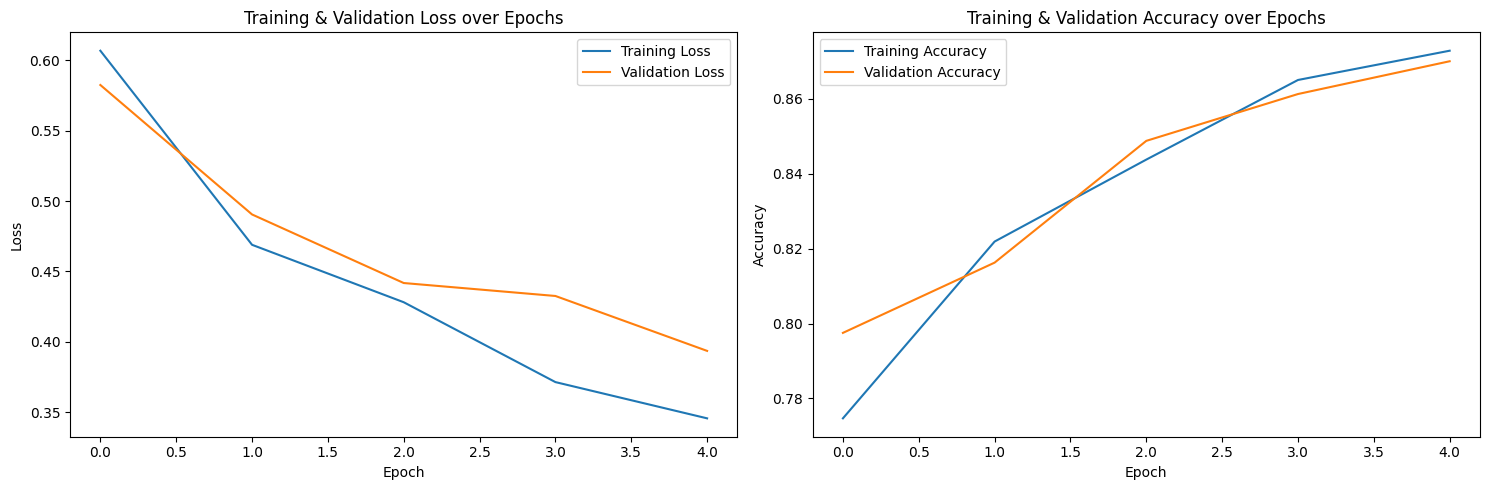

In [ ]:
import pandas as pd
import torch
import torch.optim as optim
from sklearn.utils import resample
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. Memuat dataset
file_path = "/content/segari_clean_yeah_drop888.csv"
df = pd.read_csv(file_path)

# 2. Mapping score ke label
df['label'] = df['score'].apply(lambda x: 'negative' if x in [1, 2] else ('neutral' if x == 3 else 'positive'))
label_to_id = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label_id'] = df['label'].map(label_to_id)

# 3. Resampling data
df_negative = df[df['label'] == 'negative']
df_negative_oversampled = resample(df_negative, replace=True, n_samples=500, random_state=42)

df_neutral = df[df['label'] == 'neutral']
df_neutral_oversampled = resample(df_neutral, replace=True, n_samples=500, random_state=42)

df_positive = df[df['label'] == 'positive']
df_positive_undersampled = resample(df_positive, replace=False, n_samples=3000, random_state=42)

df_resampled = pd.concat([df_negative_oversampled, df_neutral_oversampled, df_positive_undersampled])

# 4. Split resampled data dengan rasio 80-20 untuk training-validasi
train_df, valid_df = train_test_split(df_resampled, test_size=0.2, random_state=42)

# 5. Tokenization
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
train_encodings = tokenizer(train_df['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")
valid_encodings = tokenizer(valid_df['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")

# 6. DataLoader
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(train_encodings.input_ids, train_encodings.attention_mask, torch.tensor(train_df['label_id'].tolist()))
valid_dataset = TensorDataset(valid_encodings.input_ids, valid_encodings.attention_mask, torch.tensor(valid_df['label_id'].tolist()))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

# 7. Model & Optimizer
config = BertConfig.from_pretrained("indobenchmark/indobert-base-p2", num_labels=3)
config.hidden_dropout_prob = 0.5
model = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p2", config=config)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# 7a. Tambahkan Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.1, verbose=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 8. Training Loop dengan Early Stopping dan Scheduler
num_epochs = 5
best_val_loss = float('inf')
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
n_epochs_stop = 3
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_count = 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_correct += (logits.argmax(dim=1) == labels).sum().item()
        total_count += labels.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_accs.append(total_correct / total_count)

    model.eval()
    total_val_loss = 0
    total_val_correct = 0
    total_val_count = 0

    with torch.no_grad():
        for batch in valid_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss, logits = outputs.loss, outputs.logits
            total_val_loss += loss.item()
            total_val_correct += (logits.argmax(dim=1) == labels).sum().item()
            total_val_count += labels.size(0)

    avg_val_loss = total_val_loss / len(valid_loader)
    valid_losses.append(avg_val_loss)
    valid_accs.append(total_val_correct / total_val_count)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Training Acc: {train_accs[-1]:.4f}, Validation Loss: {valid_losses[-1]:.4f}, Validation Acc: {valid_accs[-1]:.4f}")

    # Update scheduler
    scheduler.step(avg_val_loss)

    # Implementasi Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == n_epochs_stop:
            print(f"Early stopping after {epochs_no_improve} epochs!")
            break

# Muat model dengan bobot terbaik
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

# Evaluasi pada data pengujian
total_test_correct = 0
total_test_count = 0
test_losses = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        test_losses.append(loss.item())
        total_test_correct += (logits.argmax(dim=1) == labels).sum().item()
        total_test_count += labels.size(0)

avg_test_loss = sum(test_losses) / len(test_losses)
test_accuracy = total_test_correct / total_test_count

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# 9. Visualization
# 9a. Visualisasi Loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss over Epochs")

# 9b. Visualisasi Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Training Accuracy")
plt.plot(valid_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy over Epochs")
plt.tight_layout()
plt.show()

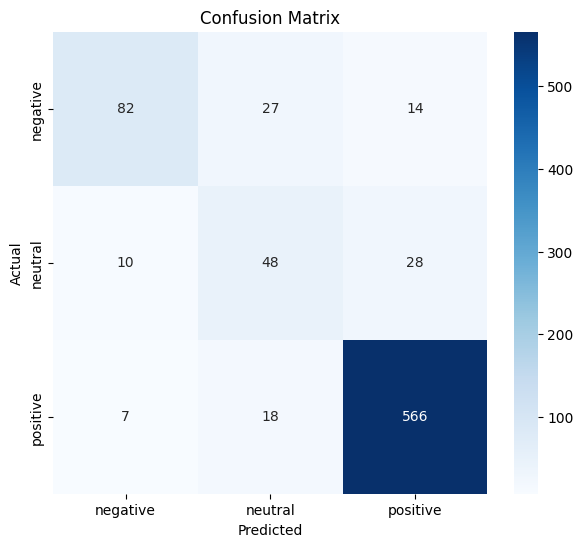

              precision    recall  f1-score   support

    negative       0.83      0.67      0.74       123
     neutral       0.52      0.56      0.54        86
    positive       0.93      0.96      0.94       591

    accuracy                           0.87       800
   macro avg       0.76      0.73      0.74       800
weighted avg       0.87      0.87      0.87       800

Accuracy Score: 0.8700


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

# 10. Evaluasi model
# Memuat model terbaik yang telah disimpan
model.load_state_dict(torch.load('best_model.pt'))

model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for batch in valid_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        all_preds.extend(logits.argmax(dim=1).cpu().numpy())
        all_true.extend(labels.cpu().numpy())

# 11. Confusion Matrix
conf_matrix = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap="Blues",
            xticklabels=label_to_id.keys(), yticklabels=label_to_id.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 12. Classification Report
report = classification_report(all_true, all_preds, target_names=label_to_id.keys())
print(report)

# 13. Accuracy Score
acc_score = accuracy_score(all_true, all_preds)
print(f"Accuracy Score: {acc_score:.4f}")

##Oversampling Negative = 500, Neutral = 500, Undersampling Positif = 3000, Epoch = 5, Learning Rate = 2e-5, Batch Size = 16, Split 80 20

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Training Loss: 0.5836, Training Acc: 0.7875, Validation Loss: 0.4826, Validation Acc: 0.8225
Epoch 2/5, Training Loss: 0.4366, Training Acc: 0.8334, Validation Loss: 0.4271, Validation Acc: 0.8438
Epoch 3/5, Training Loss: 0.3824, Training Acc: 0.8666, Validation Loss: 0.3922, Validation Acc: 0.8812
Epoch 4/5, Training Loss: 0.3398, Training Acc: 0.8831, Validation Loss: 0.3934, Validation Acc: 0.8812
Epoch 5/5, Training Loss: 0.2856, Training Acc: 0.9116, Validation Loss: 0.3707, Validation Acc: 0.9000
Test Loss: 0.2889, Test Accuracy: 0.9213


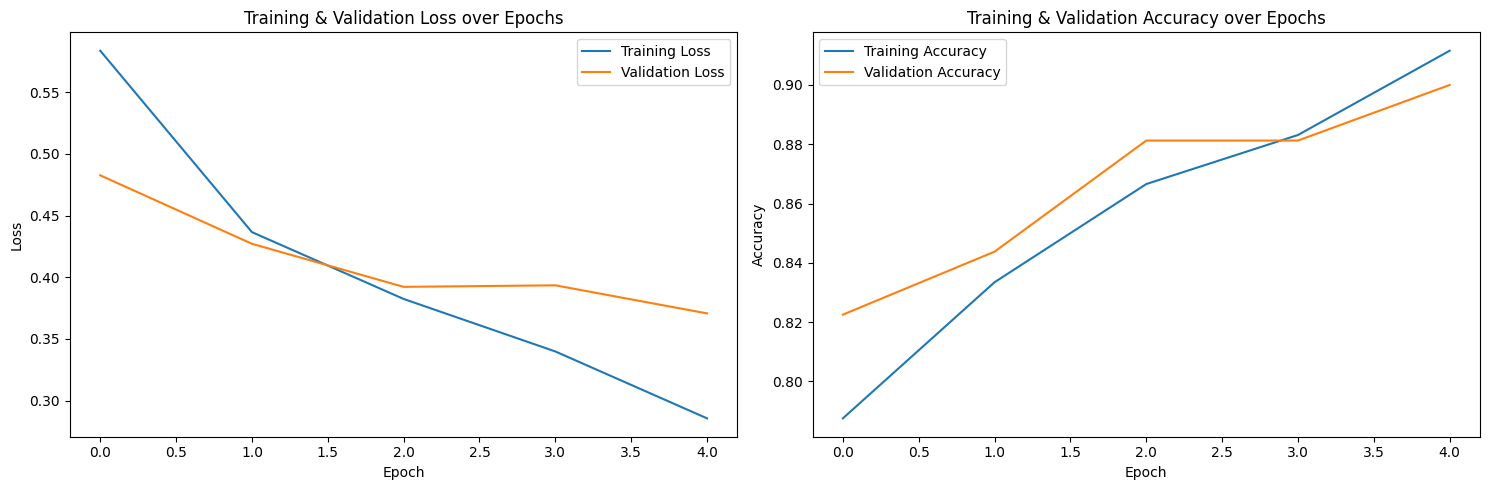

In [ ]:
import pandas as pd
import torch
import torch.optim as optim
from sklearn.utils import resample
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. Memuat dataset
file_path = "/content/segari_clean_yeah_drop888.csv"
df = pd.read_csv(file_path)

# 2. Mapping score ke label
df['label'] = df['score'].apply(lambda x: 'negative' if x in [1, 2] else ('neutral' if x == 3 else 'positive'))
label_to_id = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label_id'] = df['label'].map(label_to_id)

# 3. Resampling data
df_negative = df[df['label'] == 'negative']
df_negative_oversampled = resample(df_negative, replace=True, n_samples=500, random_state=42)

df_neutral = df[df['label'] == 'neutral']
df_neutral_oversampled = resample(df_neutral, replace=True, n_samples=500, random_state=42)

df_positive = df[df['label'] == 'positive']
df_positive_undersampled = resample(df_positive, replace=False, n_samples=3000, random_state=42)

df_resampled = pd.concat([df_negative_oversampled, df_neutral_oversampled, df_positive_undersampled])

# 4. Split resampled data dengan rasio 80-20 untuk training-validasi
train_df, valid_df = train_test_split(df_resampled, test_size=0.2, random_state=42)

# 5. Tokenization
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
train_encodings = tokenizer(train_df['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")
valid_encodings = tokenizer(valid_df['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")

# 6. DataLoader
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(train_encodings.input_ids, train_encodings.attention_mask, torch.tensor(train_df['label_id'].tolist()))
valid_dataset = TensorDataset(valid_encodings.input_ids, valid_encodings.attention_mask, torch.tensor(valid_df['label_id'].tolist()))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

# 7. Model & Optimizer
config = BertConfig.from_pretrained("indobenchmark/indobert-base-p2", num_labels=3)
config.hidden_dropout_prob = 0.5
model = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p2", config=config)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

# 7a. Tambahkan Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.1, verbose=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 8. Training Loop dengan Early Stopping dan Scheduler
num_epochs = 5
best_val_loss = float('inf')
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
n_epochs_stop = 3
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_count = 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_correct += (logits.argmax(dim=1) == labels).sum().item()
        total_count += labels.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_accs.append(total_correct / total_count)

    model.eval()
    total_val_loss = 0
    total_val_correct = 0
    total_val_count = 0

    with torch.no_grad():
        for batch in valid_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss, logits = outputs.loss, outputs.logits
            total_val_loss += loss.item()
            total_val_correct += (logits.argmax(dim=1) == labels).sum().item()
            total_val_count += labels.size(0)

    avg_val_loss = total_val_loss / len(valid_loader)
    valid_losses.append(avg_val_loss)
    valid_accs.append(total_val_correct / total_val_count)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Training Acc: {train_accs[-1]:.4f}, Validation Loss: {valid_losses[-1]:.4f}, Validation Acc: {valid_accs[-1]:.4f}")

    # Update scheduler
    scheduler.step(avg_val_loss)

    # Implementasi Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == n_epochs_stop:
            print(f"Early stopping after {epochs_no_improve} epochs!")
            break

# Muat model dengan bobot terbaik
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

# Evaluasi pada data pengujian
total_test_correct = 0
total_test_count = 0
test_losses = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        test_losses.append(loss.item())
        total_test_correct += (logits.argmax(dim=1) == labels).sum().item()
        total_test_count += labels.size(0)

avg_test_loss = sum(test_losses) / len(test_losses)
test_accuracy = total_test_correct / total_test_count

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# 9. Visualization
# 9a. Visualisasi Loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss over Epochs")

# 9b. Visualisasi Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Training Accuracy")
plt.plot(valid_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy over Epochs")
plt.tight_layout()
plt.show()

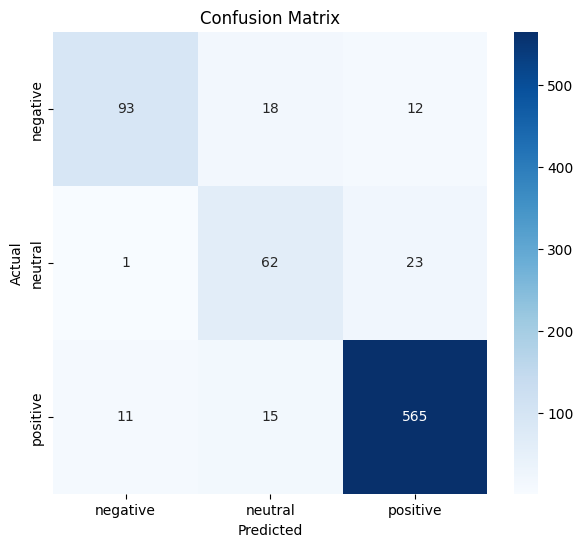

              precision    recall  f1-score   support

    negative       0.89      0.76      0.82       123
     neutral       0.65      0.72      0.69        86
    positive       0.94      0.96      0.95       591

    accuracy                           0.90       800
   macro avg       0.83      0.81      0.82       800
weighted avg       0.90      0.90      0.90       800

Accuracy Score: 0.9000


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

# 10. Evaluasi model
# Memuat model terbaik yang telah disimpan
model.load_state_dict(torch.load('best_model.pt'))

model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for batch in valid_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        all_preds.extend(logits.argmax(dim=1).cpu().numpy())
        all_true.extend(labels.cpu().numpy())

# 11. Confusion Matrix
conf_matrix = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap="Blues",
            xticklabels=label_to_id.keys(), yticklabels=label_to_id.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 12. Classification Report
report = classification_report(all_true, all_preds, target_names=label_to_id.keys())
print(report)

# 13. Accuracy Score
acc_score = accuracy_score(all_true, all_preds)
print(f"Accuracy Score: {acc_score:.4f}")

##Oversampling Negative = 500, Neutral = 500, Undersampling Positif = 3000, Epoch = 5, Learning Rate = 3e-5, Batch Size = 16, Split 80 20

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Training Loss: 0.6394, Training Acc: 0.7700, Validation Loss: 0.5379, Validation Acc: 0.8150
Epoch 2/5, Training Loss: 0.4733, Training Acc: 0.8231, Validation Loss: 0.4590, Validation Acc: 0.8438
Epoch 3/5, Training Loss: 0.3986, Training Acc: 0.8509, Validation Loss: 0.3963, Validation Acc: 0.8662
Epoch 4/5, Training Loss: 0.3548, Training Acc: 0.8809, Validation Loss: 0.3827, Validation Acc: 0.8725
Epoch 5/5, Training Loss: 0.3099, Training Acc: 0.8956, Validation Loss: 0.4037, Validation Acc: 0.8825


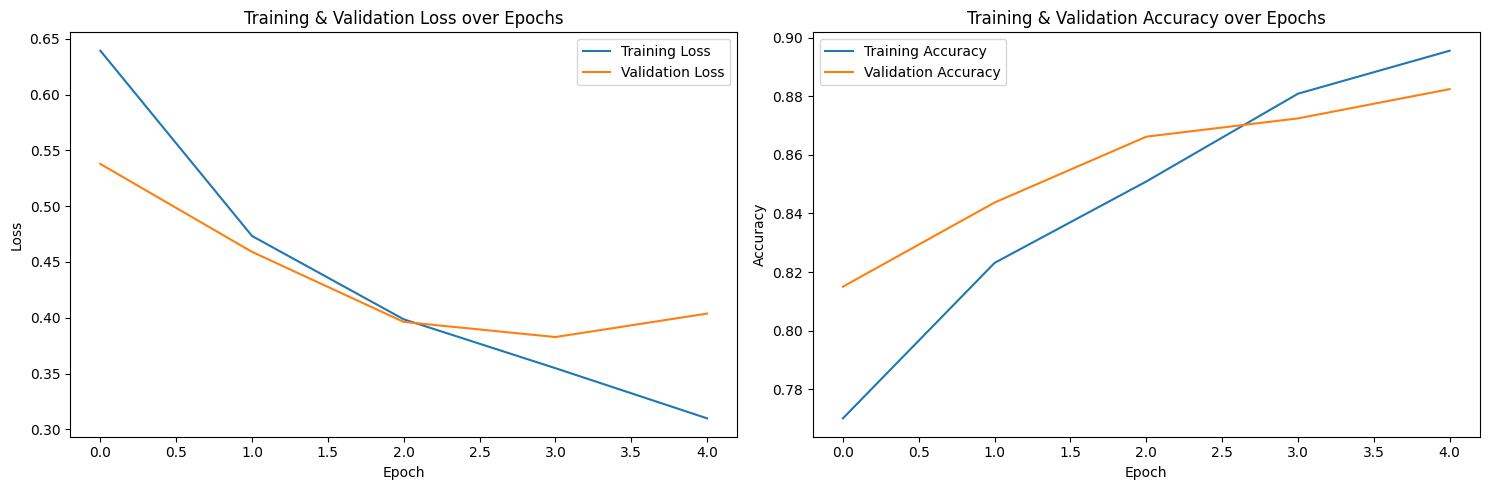

In [8]:
import pandas as pd
import torch
import torch.optim as optim
from sklearn.utils import resample
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. Memuat dataset
file_path = "/content/segari_clean_yeah_drop888.csv"
df = pd.read_csv(file_path)

# 2. Mapping score ke label
df['label'] = df['score'].apply(lambda x: 'negative' if x in [1, 2] else ('neutral' if x == 3 else 'positive'))
label_to_id = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label_id'] = df['label'].map(label_to_id)

# 3. Resampling data
df_negative = df[df['label'] == 'negative']
df_negative_oversampled = resample(df_negative, replace=True, n_samples=500, random_state=42)

df_neutral = df[df['label'] == 'neutral']
df_neutral_oversampled = resample(df_neutral, replace=True, n_samples=500, random_state=42)

df_positive = df[df['label'] == 'positive']
df_positive_undersampled = resample(df_positive, replace=False, n_samples=3000, random_state=42)

df_resampled = pd.concat([df_negative_oversampled, df_neutral_oversampled, df_positive_undersampled])

# 4. Split resampled data dengan rasio 80-20 untuk training-validasi
train_df, valid_df = train_test_split(df_resampled, test_size=0.2, random_state=42)

# 5. Tokenization
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
train_encodings = tokenizer(train_df['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")
valid_encodings = tokenizer(valid_df['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")

# 6. DataLoader
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(train_encodings.input_ids, train_encodings.attention_mask, torch.tensor(train_df['label_id'].tolist()))
valid_dataset = TensorDataset(valid_encodings.input_ids, valid_encodings.attention_mask, torch.tensor(valid_df['label_id'].tolist()))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

# 7. Model & Optimizer
config = BertConfig.from_pretrained("indobenchmark/indobert-base-p2", num_labels=3)
config.hidden_dropout_prob = 0.5
model = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p2", config=config)
optimizer = optim.Adam(model.parameters(), lr=3e-5)

# 7a. Tambahkan Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.1, verbose=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 8. Training Loop dengan Early Stopping dan Scheduler
num_epochs = 5
best_val_loss = float('inf')
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
n_epochs_stop = 3
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_count = 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_correct += (logits.argmax(dim=1) == labels).sum().item()
        total_count += labels.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_accs.append(total_correct / total_count)

    model.eval()
    total_val_loss = 0
    total_val_correct = 0
    total_val_count = 0

    with torch.no_grad():
        for batch in valid_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss, logits = outputs.loss, outputs.logits
            total_val_loss += loss.item()
            total_val_correct += (logits.argmax(dim=1) == labels).sum().item()
            total_val_count += labels.size(0)

    avg_val_loss = total_val_loss / len(valid_loader)
    valid_losses.append(avg_val_loss)
    valid_accs.append(total_val_correct / total_val_count)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Training Acc: {train_accs[-1]:.4f}, Validation Loss: {valid_losses[-1]:.4f}, Validation Acc: {valid_accs[-1]:.4f}")

    # Update scheduler
    scheduler.step(avg_val_loss)

    # Implementasi Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == n_epochs_stop:
            print(f"Early stopping after {epochs_no_improve} epochs!")
            break

# Muat model dengan bobot terbaik
model.load_state_dict(torch.load('best_model.pt'))
model.eval()


# 9. Visualization
# 9a. Visualisasi Loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss over Epochs")

# 9b. Visualisasi Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Training Accuracy")
plt.plot(valid_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy over Epochs")
plt.tight_layout()
plt.show()

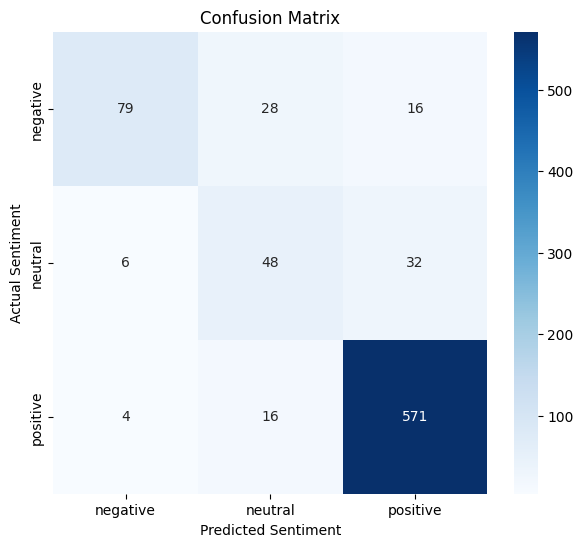

              precision    recall  f1-score   support

    negative       0.89      0.64      0.75       123
     neutral       0.52      0.56      0.54        86
    positive       0.92      0.97      0.94       591

    accuracy                           0.87       800
   macro avg       0.78      0.72      0.74       800
weighted avg       0.87      0.87      0.87       800

Accuracy Score: 0.8725


In [9]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

# 10. Evaluasi model
# Memuat model terbaik yang telah disimpan
model.load_state_dict(torch.load('best_model.pt'))

model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for batch in valid_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        all_preds.extend(logits.argmax(dim=1).cpu().numpy())
        all_true.extend(labels.cpu().numpy())

# 11. Confusion Matrix
conf_matrix = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap="Blues",
            xticklabels=label_to_id.keys(), yticklabels=label_to_id.keys())
plt.xlabel('Predicted Sentiment')
plt.ylabel('Actual Sentiment')
plt.title('Confusion Matrix')
plt.show()

# 12. Classification Report
report = classification_report(all_true, all_preds, target_names=label_to_id.keys())
print(report)

# 13. Accuracy Score
acc_score = accuracy_score(all_true, all_preds)
print(f"Accuracy Score: {acc_score:.4f}")

##Oversampling Negative = 500, Neutral = 500, Undersampling Positif = 3000, Epoch = 5, Learning Rate = 2e-5, Batch Size = 32, Split 80 20 (INI DIPAKE JADINYA)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Training Loss: 0.6448, Training Acc: 0.7619, Validation Loss: 0.5992, Validation Acc: 0.7963
Epoch 2/5, Training Loss: 0.4816, Training Acc: 0.8141, Validation Loss: 0.5048, Validation Acc: 0.8350
Epoch 3/5, Training Loss: 0.4177, Training Acc: 0.8409, Validation Loss: 0.4270, Validation Acc: 0.8450
Epoch 4/5, Training Loss: 0.3765, Training Acc: 0.8631, Validation Loss: 0.4036, Validation Acc: 0.8650
Epoch 5/5, Training Loss: 0.3359, Training Acc: 0.8838, Validation Loss: 0.3643, Validation Acc: 0.8800


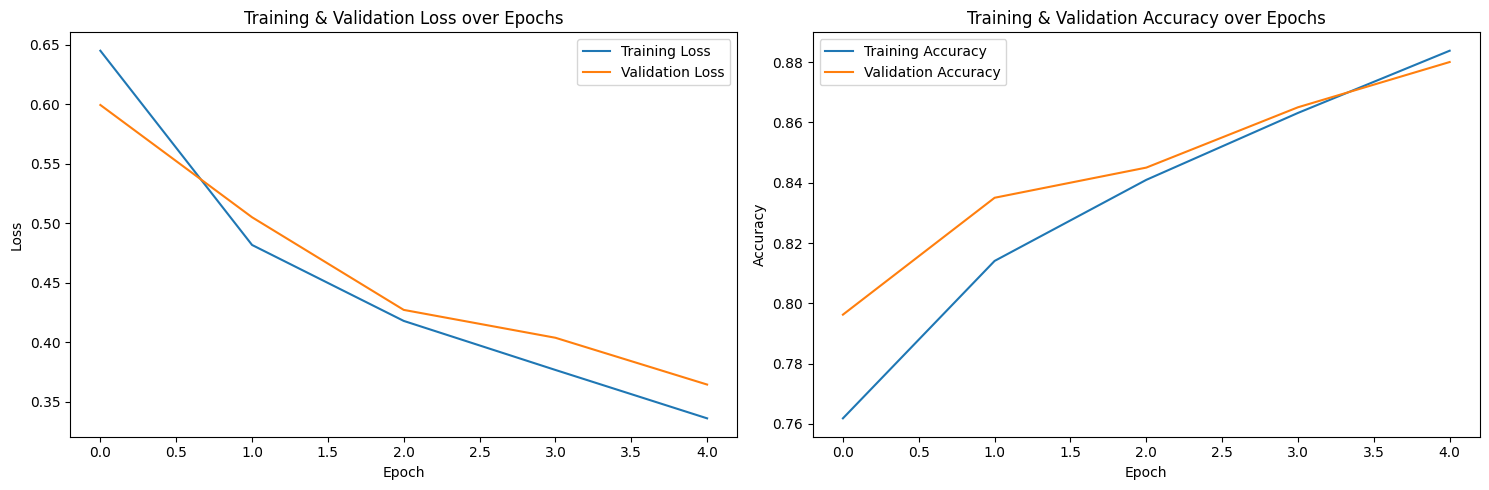

In [4]:
import pandas as pd
import torch
import torch.optim as optim
from sklearn.utils import resample
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. Memuat dataset
file_path = "/content/segari_clean_yeah_drop888.csv"
df = pd.read_csv(file_path)

# 2. Mapping score ke label
df['label'] = df['score'].apply(lambda x: 'negative' if x in [1, 2] else ('neutral' if x == 3 else 'positive'))
label_to_id = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label_id'] = df['label'].map(label_to_id)

# 3. Resampling data
df_negative = df[df['label'] == 'negative']
df_negative_oversampled = resample(df_negative, replace=True, n_samples=500, random_state=42)

df_neutral = df[df['label'] == 'neutral']
df_neutral_oversampled = resample(df_neutral, replace=True, n_samples=500, random_state=42)

df_positive = df[df['label'] == 'positive']
df_positive_undersampled = resample(df_positive, replace=False, n_samples=3000, random_state=42)

df_resampled = pd.concat([df_negative_oversampled, df_neutral_oversampled, df_positive_undersampled])

# 4. Split resampled data dengan rasio 80-20 untuk training-validasi
train_df, valid_df = train_test_split(df_resampled, test_size=0.2, random_state=42)

# 5. Tokenization
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
train_encodings = tokenizer(train_df['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")
valid_encodings = tokenizer(valid_df['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")

# 6. DataLoader
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(train_encodings.input_ids, train_encodings.attention_mask, torch.tensor(train_df['label_id'].tolist()))
valid_dataset = TensorDataset(valid_encodings.input_ids, valid_encodings.attention_mask, torch.tensor(valid_df['label_id'].tolist()))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# 7. Model & Optimizer
config = BertConfig.from_pretrained("indobenchmark/indobert-base-p2", num_labels=3)
config.hidden_dropout_prob = 0.5
model = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p2", config=config)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

# 7a. Tambahkan Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.1, verbose=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 8. Training Loop dengan Early Stopping dan Scheduler
num_epochs = 5
best_val_loss = float('inf')
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
n_epochs_stop = 3
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_count = 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_correct += (logits.argmax(dim=1) == labels).sum().item()
        total_count += labels.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_accs.append(total_correct / total_count)

    model.eval()
    total_val_loss = 0
    total_val_correct = 0
    total_val_count = 0

    with torch.no_grad():
        for batch in valid_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss, logits = outputs.loss, outputs.logits
            total_val_loss += loss.item()
            total_val_correct += (logits.argmax(dim=1) == labels).sum().item()
            total_val_count += labels.size(0)

    avg_val_loss = total_val_loss / len(valid_loader)
    valid_losses.append(avg_val_loss)
    valid_accs.append(total_val_correct / total_val_count)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Training Acc: {train_accs[-1]:.4f}, Validation Loss: {valid_losses[-1]:.4f}, Validation Acc: {valid_accs[-1]:.4f}")

    # Update scheduler
    scheduler.step(avg_val_loss)

    # Implementasi Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == n_epochs_stop:
            print(f"Early stopping after {epochs_no_improve} epochs!")
            break

# Muat model dengan bobot terbaik
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

# 9. Visualization
# 9a. Visualisasi Loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss over Epochs")

# 9b. Visualisasi Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Training Accuracy")
plt.plot(valid_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy over Epochs")
plt.tight_layout()
plt.show()

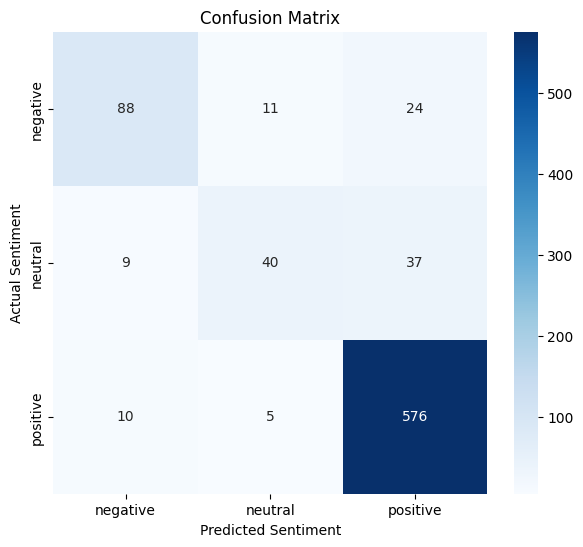

              precision    recall  f1-score   support

    negative       0.82      0.72      0.77       123
     neutral       0.71      0.47      0.56        86
    positive       0.90      0.97      0.94       591

    accuracy                           0.88       800
   macro avg       0.81      0.72      0.76       800
weighted avg       0.87      0.88      0.87       800

Accuracy Score: 0.8800


In [5]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

# 10. Evaluasi model
# Memuat model terbaik yang telah disimpan
model.load_state_dict(torch.load('best_model.pt'))

model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for batch in valid_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        all_preds.extend(logits.argmax(dim=1).cpu().numpy())
        all_true.extend(labels.cpu().numpy())

# 11. Confusion Matrix
conf_matrix = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap="Blues",
            xticklabels=label_to_id.keys(), yticklabels=label_to_id.keys())
plt.xlabel('Predicted Sentiment')
plt.ylabel('Actual Sentiment')
plt.title('Confusion Matrix')
plt.show()

# 12. Classification Report
report = classification_report(all_true, all_preds, target_names=label_to_id.keys())
print(report)

# 13. Accuracy Score
acc_score = accuracy_score(all_true, all_preds)
print(f"Accuracy Score: {acc_score:.4f}")

##Oversampling Negative = 500, Neutral = 500, Undersampling Positif = 3000, Epoch = 5, Learning Rate = 3e-5, Batch Size = 32, Split 80 20 (TIDAK)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Training Loss: 0.7261, Training Acc: 0.7416, Validation Loss: 0.6629, Validation Acc: 0.7575
Epoch 2/5, Training Loss: 0.6120, Training Acc: 0.7756, Validation Loss: 0.6908, Validation Acc: 0.7550
Epoch 3/5, Training Loss: 0.5317, Training Acc: 0.7941, Validation Loss: 0.6423, Validation Acc: 0.7925
Epoch 4/5, Training Loss: 0.4861, Training Acc: 0.8106, Validation Loss: 0.5974, Validation Acc: 0.8063
Epoch 5/5, Training Loss: 0.4752, Training Acc: 0.8184, Validation Loss: 0.5312, Validation Acc: 0.8075


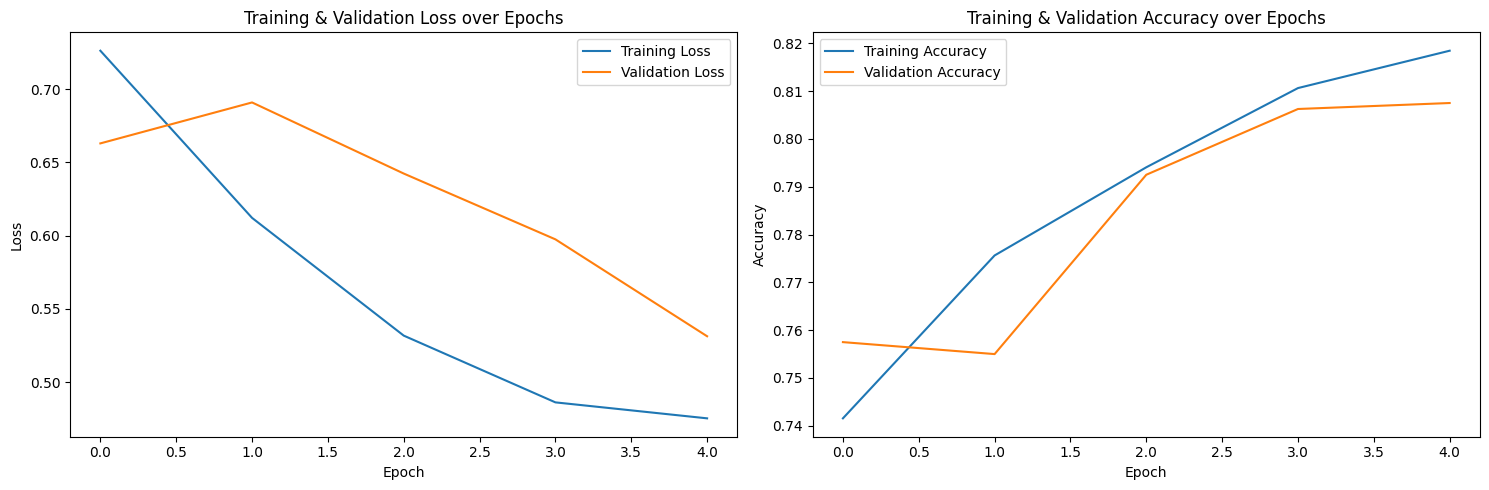

In [12]:
import pandas as pd
import torch
import torch.optim as optim
from sklearn.utils import resample
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. Memuat dataset
file_path = "/content/segari_clean_yeah_drop888.csv"
df = pd.read_csv(file_path)

# 2. Mapping score ke label
df['label'] = df['score'].apply(lambda x: 'negative' if x in [1, 2] else ('neutral' if x == 3 else 'positive'))
label_to_id = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label_id'] = df['label'].map(label_to_id)

# 3. Resampling data
df_negative = df[df['label'] == 'negative']
df_negative_oversampled = resample(df_negative, replace=True, n_samples=500, random_state=42)

df_neutral = df[df['label'] == 'neutral']
df_neutral_oversampled = resample(df_neutral, replace=True, n_samples=500, random_state=42)

df_positive = df[df['label'] == 'positive']
df_positive_undersampled = resample(df_positive, replace=False, n_samples=3000, random_state=42)

df_resampled = pd.concat([df_negative_oversampled, df_neutral_oversampled, df_positive_undersampled])

# 4. Split resampled data dengan rasio 80-20 untuk training-validasi
train_df, valid_df = train_test_split(df_resampled, test_size=0.2, random_state=42)

# 5. Tokenization
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
train_encodings = tokenizer(train_df['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")
valid_encodings = tokenizer(valid_df['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")

# 6. DataLoader
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(train_encodings.input_ids, train_encodings.attention_mask, torch.tensor(train_df['label_id'].tolist()))
valid_dataset = TensorDataset(valid_encodings.input_ids, valid_encodings.attention_mask, torch.tensor(valid_df['label_id'].tolist()))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# 7. Model & Optimizer
config = BertConfig.from_pretrained("indobenchmark/indobert-base-p2", num_labels=3)
config.hidden_dropout_prob = 0.5
model = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p2", config=config)
optimizer = optim.Adam(model.parameters(), lr=3e-6)

# 7a. Tambahkan Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.1, verbose=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 8. Training Loop dengan Early Stopping dan Scheduler
num_epochs = 5
best_val_loss = float('inf')
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
n_epochs_stop = 3
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_count = 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_correct += (logits.argmax(dim=1) == labels).sum().item()
        total_count += labels.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_accs.append(total_correct / total_count)

    model.eval()
    total_val_loss = 0
    total_val_correct = 0
    total_val_count = 0

    with torch.no_grad():
        for batch in valid_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss, logits = outputs.loss, outputs.logits
            total_val_loss += loss.item()
            total_val_correct += (logits.argmax(dim=1) == labels).sum().item()
            total_val_count += labels.size(0)

    avg_val_loss = total_val_loss / len(valid_loader)
    valid_losses.append(avg_val_loss)
    valid_accs.append(total_val_correct / total_val_count)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Training Acc: {train_accs[-1]:.4f}, Validation Loss: {valid_losses[-1]:.4f}, Validation Acc: {valid_accs[-1]:.4f}")

    # Update scheduler
    scheduler.step(avg_val_loss)

    # Implementasi Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == n_epochs_stop:
            print(f"Early stopping after {epochs_no_improve} epochs!")
            break

# Muat model dengan bobot terbaik
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

# 9. Visualization
# 9a. Visualisasi Loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss over Epochs")

# 9b. Visualisasi Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Training Accuracy")
plt.plot(valid_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy over Epochs")
plt.tight_layout()
plt.show()

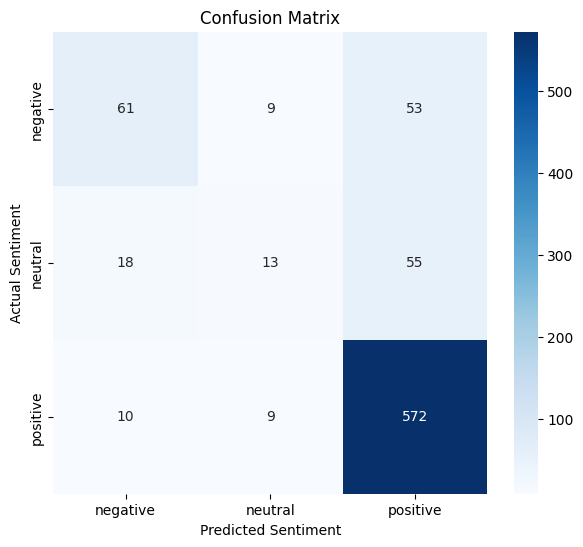

              precision    recall  f1-score   support

    negative       0.69      0.50      0.58       123
     neutral       0.42      0.15      0.22        86
    positive       0.84      0.97      0.90       591

    accuracy                           0.81       800
   macro avg       0.65      0.54      0.57       800
weighted avg       0.77      0.81      0.78       800

Accuracy Score: 0.8075


In [13]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

# 10. Evaluasi model
# Memuat model terbaik yang telah disimpan
model.load_state_dict(torch.load('best_model.pt'))

model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for batch in valid_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        all_preds.extend(logits.argmax(dim=1).cpu().numpy())
        all_true.extend(labels.cpu().numpy())

# 11. Confusion Matrix
conf_matrix = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap="Blues",
            xticklabels=label_to_id.keys(), yticklabels=label_to_id.keys())
plt.xlabel('Predicted Sentiment')
plt.ylabel('Actual Sentiment')
plt.title('Confusion Matrix')
plt.show()

# 12. Classification Report
report = classification_report(all_true, all_preds, target_names=label_to_id.keys())
print(report)

# 13. Accuracy Score
acc_score = accuracy_score(all_true, all_preds)
print(f"Accuracy Score: {acc_score:.4f}")

##Oversampling Negative = 500, Neutral = 500, Undersampling Positif = 3000, Epoch = 5, Learning Rate = 3e-6, Batch Size = 32, Split 80 20 (TIDAK)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Training Loss: 0.7563, Training Acc: 0.7181, Validation Loss: 0.7406, Validation Acc: 0.7388
Epoch 2/5, Training Loss: 0.6533, Training Acc: 0.7681, Validation Loss: 0.6952, Validation Acc: 0.7550
Epoch 3/5, Training Loss: 0.5605, Training Acc: 0.7878, Validation Loss: 0.7330, Validation Acc: 0.7738
Epoch 4/5, Training Loss: 0.5109, Training Acc: 0.7969, Validation Loss: 0.6914, Validation Acc: 0.7900
Epoch 5/5, Training Loss: 0.4975, Training Acc: 0.8034, Validation Loss: 0.7384, Validation Acc: 0.7725


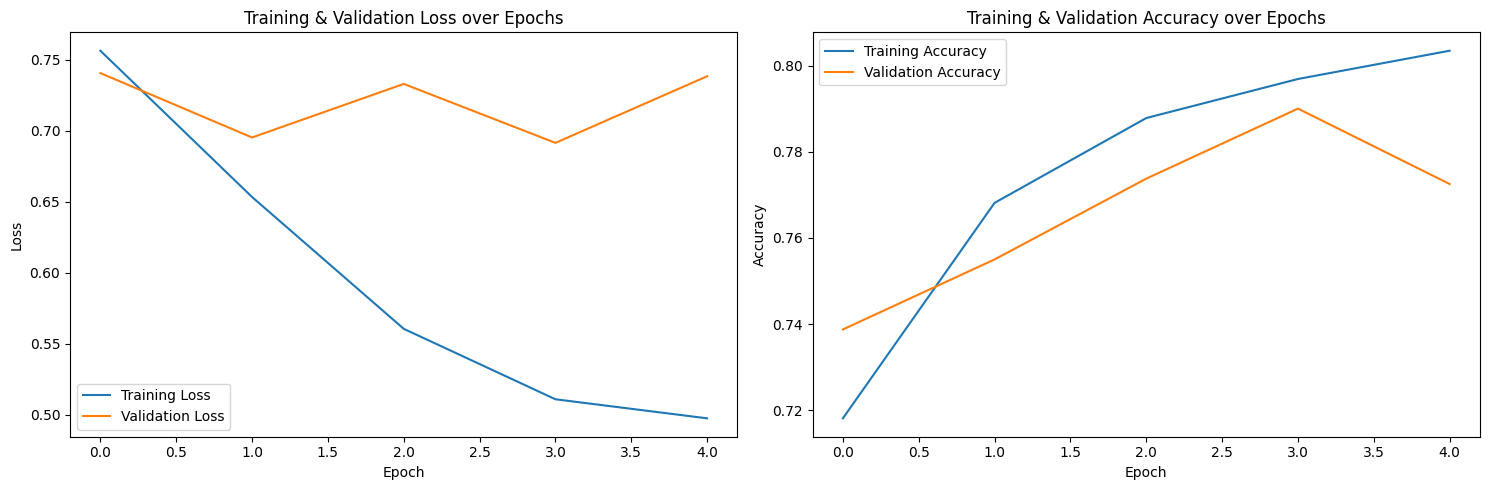

In [14]:
import pandas as pd
import torch
import torch.optim as optim
from sklearn.utils import resample
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. Memuat dataset
file_path = "/content/segari_clean_yeah_drop888.csv"
df = pd.read_csv(file_path)

# 2. Mapping score ke label
df['label'] = df['score'].apply(lambda x: 'negative' if x in [1, 2] else ('neutral' if x == 3 else 'positive'))
label_to_id = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label_id'] = df['label'].map(label_to_id)

# 3. Resampling data
df_negative = df[df['label'] == 'negative']
df_negative_oversampled = resample(df_negative, replace=True, n_samples=500, random_state=42)

df_neutral = df[df['label'] == 'neutral']
df_neutral_oversampled = resample(df_neutral, replace=True, n_samples=500, random_state=42)

df_positive = df[df['label'] == 'positive']
df_positive_undersampled = resample(df_positive, replace=False, n_samples=3000, random_state=42)

df_resampled = pd.concat([df_negative_oversampled, df_neutral_oversampled, df_positive_undersampled])

# 4. Split resampled data dengan rasio 80-20 untuk training-validasi
train_df, valid_df = train_test_split(df_resampled, test_size=0.2, random_state=42)

# 5. Tokenization
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
train_encodings = tokenizer(train_df['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")
valid_encodings = tokenizer(valid_df['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")

# 6. DataLoader
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(train_encodings.input_ids, train_encodings.attention_mask, torch.tensor(train_df['label_id'].tolist()))
valid_dataset = TensorDataset(valid_encodings.input_ids, valid_encodings.attention_mask, torch.tensor(valid_df['label_id'].tolist()))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# 7. Model & Optimizer
config = BertConfig.from_pretrained("indobenchmark/indobert-base-p2", num_labels=3)
config.hidden_dropout_prob = 0.5
model = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p2", config=config)
optimizer = optim.Adam(model.parameters(), lr=3e-6)

# 7a. Tambahkan Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.1, verbose=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 8. Training Loop dengan Early Stopping dan Scheduler
num_epochs = 5
best_val_loss = float('inf')
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
n_epochs_stop = 3
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_count = 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_correct += (logits.argmax(dim=1) == labels).sum().item()
        total_count += labels.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_accs.append(total_correct / total_count)

    model.eval()
    total_val_loss = 0
    total_val_correct = 0
    total_val_count = 0

    with torch.no_grad():
        for batch in valid_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss, logits = outputs.loss, outputs.logits
            total_val_loss += loss.item()
            total_val_correct += (logits.argmax(dim=1) == labels).sum().item()
            total_val_count += labels.size(0)

    avg_val_loss = total_val_loss / len(valid_loader)
    valid_losses.append(avg_val_loss)
    valid_accs.append(total_val_correct / total_val_count)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Training Acc: {train_accs[-1]:.4f}, Validation Loss: {valid_losses[-1]:.4f}, Validation Acc: {valid_accs[-1]:.4f}")

    # Update scheduler
    scheduler.step(avg_val_loss)

    # Implementasi Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == n_epochs_stop:
            print(f"Early stopping after {epochs_no_improve} epochs!")
            break

# Muat model dengan bobot terbaik
model.load_state_dict(torch.load('best_model.pt'))
model.eval()


# 9. Visualization
# 9a. Visualisasi Loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss over Epochs")

# 9b. Visualisasi Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Training Accuracy")
plt.plot(valid_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy over Epochs")
plt.tight_layout()
plt.show()

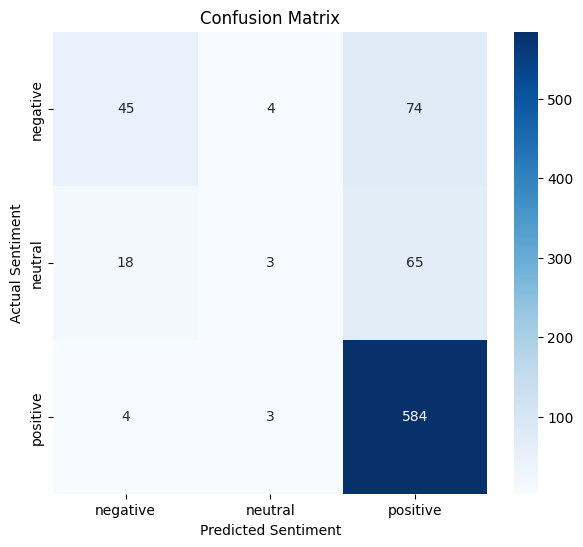

              precision    recall  f1-score   support

    negative       0.67      0.37      0.47       123
     neutral       0.30      0.03      0.06        86
    positive       0.81      0.99      0.89       591

    accuracy                           0.79       800
   macro avg       0.59      0.46      0.48       800
weighted avg       0.73      0.79      0.74       800

Accuracy Score: 0.7900


In [15]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

# 10. Evaluasi model
# Memuat model terbaik yang telah disimpan
model.load_state_dict(torch.load('best_model.pt'))

model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for batch in valid_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        all_preds.extend(logits.argmax(dim=1).cpu().numpy())
        all_true.extend(labels.cpu().numpy())

# 11. Confusion Matrix
conf_matrix = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap="Blues",
            xticklabels=label_to_id.keys(), yticklabels=label_to_id.keys())
plt.xlabel('Predicted Sentiment')
plt.ylabel('Actual Sentiment')
plt.title('Confusion Matrix')
plt.show()

# 12. Classification Report
report = classification_report(all_true, all_preds, target_names=label_to_id.keys())
print(report)

# 13. Accuracy Score
acc_score = accuracy_score(all_true, all_preds)
print(f"Accuracy Score: {acc_score:.4f}")